# Hybrid Dataset

## Creating Hybrid dataset

In [1]:
"""
Create hybrid dataset combining normal trajectories, AURSAD-like failures, and synthetic degradations
"""

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

CONFIG = {
    'n_normal': 150,        # RoboNet-like normal trajectories
    'n_aursad': 400,        # AURSAD-like failure trajectories
    'n_synthetic_per_type': 2,  # Synthetic degradations per normal trajectory
    'sampling_rate': 100,   # Hz
    'max_duration': 7,      # seconds
}
print(f"\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

def generate_normal_trajectories(n_trajectories, sampling_rate=100):
    """Generate diverse normal robot behaviors (RoboNet-like)."""

    all_data = []

    for sample_id in tqdm(range(n_trajectories), desc="Normal Trajectories"):
        duration = np.random.uniform(3, 7)
        n_timesteps = int(duration * sampling_rate)
        t = np.linspace(0, duration, n_timesteps)

        pattern_type = np.random.choice(['sinusoidal', 'polynomial', 'step'])

        traj_data = {
            'sample_id': sample_id,
            'time': t,
            'label': 'normal',
            'source': 'generated_normal'
        }

        for joint in range(6):
            if pattern_type == 'sinusoidal':
                freq = np.random.uniform(0.3, 0.8)
                amp = np.random.uniform(1.0, 2.0)
                phase = np.random.uniform(0, 2*np.pi)
                position = amp * np.sin(2 * np.pi * freq * t + phase) + 0.02 * np.random.randn(n_timesteps)
                velocity = 2 * np.pi * freq * amp * np.cos(2 * np.pi * freq * t + phase) + 0.05 * np.random.randn(n_timesteps)

            elif pattern_type == 'polynomial':
                coefs = np.random.randn(4) * 0.3
                position = np.polyval(coefs, t/duration) + 0.02 * np.random.randn(n_timesteps)
                velocity = np.gradient(position, t) + 0.05 * np.random.randn(n_timesteps)

            else:  # step response
                tau = np.random.uniform(0.5, 1.5)
                position = 1.5 * (1 - np.exp(-t/tau)) + 0.02 * np.random.randn(n_timesteps)
                velocity = (1.5/tau) * np.exp(-t/tau) + 0.05 * np.random.randn(n_timesteps)

            current = 1.0 + 0.25 * np.abs(velocity) + 0.08 * np.random.randn(n_timesteps)

            traj_data[f'q{joint+1}'] = position
            traj_data[f'qd{joint+1}'] = velocity
            traj_data[f'i{joint+1}'] = current

        all_data.append(pd.DataFrame(traj_data))

    return pd.concat(all_data, ignore_index=True)

def generate_aursad_failures(n_samples, sampling_rate=100):
    """Generate AURSAD-like real failure trajectories."""

    # AURSAD label distribution
    labels = np.concatenate([
        np.repeat('normal', int(n_samples * 0.70)),
        np.repeat('damaged_screw', int(n_samples * 0.11)),
        np.repeat('extra_component', int(n_samples * 0.09)),
        np.repeat('missing_screw', int(n_samples * 0.09)),
        np.repeat('damaged_thread', int(n_samples * 0.01))
    ])

    all_data = []

    for sample_id, label in enumerate(tqdm(labels, desc="AURSAD Failures")):
        duration = 5.0
        n_timesteps = int(duration * sampling_rate)
        t = np.linspace(0, duration, n_timesteps)

        traj_data = {
            'sample_id': sample_id + 10000,
            'time': t,
            'label': label,
            'source': 'aursad_like'
        }

        for joint in range(6):
            freq = 0.5 + joint * 0.05
            phase = joint * np.pi / 6

            position = 1.5 * np.sin(2 * np.pi * freq * t + phase)
            velocity = 2 * np.pi * freq * 1.5 * np.cos(2 * np.pi * freq * t + phase)

            # Apply fault signatures
            if label == 'damaged_screw':
                position += 0.1 * np.random.randn(n_timesteps)
                velocity += 0.3 * np.sin(2 * np.pi * 12 * t)
                current = 1.5 + 0.4 * np.abs(velocity) + 0.25 * np.random.randn(n_timesteps)

            elif label == 'missing_screw':
                position += 0.08 * t + 0.12 * np.random.randn(n_timesteps)
                velocity += 0.25 * np.random.randn(n_timesteps)
                current = 1.2 + 0.3 * np.abs(velocity) + 0.2 * np.random.randn(n_timesteps)

            elif label == 'extra_component':
                position += 0.06 * np.random.randn(n_timesteps)
                velocity *= 0.85
                current = 1.8 + 0.5 * np.abs(velocity) + 0.3 * np.random.randn(n_timesteps)
                spike_mask = np.random.rand(n_timesteps) > 0.95
                current[spike_mask] += 2.0

            elif label == 'damaged_thread':
                position += 0.15 * np.sin(2 * np.pi * 45 * t)
                velocity += 0.25 * np.sin(2 * np.pi * 45 * t)
                current = 1.4 + 0.4 * np.abs(velocity) + 0.35 * np.random.randn(n_timesteps)

            else:  # normal
                current = 1.0 + 0.25 * np.abs(velocity) + 0.1 * np.random.randn(n_timesteps)

            traj_data[f'q{joint+1}'] = position
            traj_data[f'qd{joint+1}'] = velocity
            traj_data[f'i{joint+1}'] = current

        all_data.append(pd.DataFrame(traj_data))

    return pd.concat(all_data, ignore_index=True)

def apply_degradation(traj_df, deg_type, severity=1.0):
    """Apply physics-based degradation pattern."""
    degraded = traj_df.copy()
    t = degraded['time'].values
    n = len(t)

    if deg_type == 'bearing_wear':
        bearing_freq = 85.0  # BPFO frequency
        for joint in range(6):
            degraded[f'q{joint+1}'] += severity * 0.02 * np.sin(2 * np.pi * bearing_freq * t)
            degraded[f'qd{joint+1}'] += severity * 0.15 * np.sin(2 * np.pi * bearing_freq * t)
            degraded[f'i{joint+1}'] *= (1 + severity * 0.2)

    elif deg_type == 'gear_backlash':
        for joint in range(6):
            direction_changes = np.diff(np.sign(degraded[f'qd{joint+1}']), prepend=0)
            backlash = severity * 0.08 * direction_changes
            degraded[f'q{joint+1}'] += np.cumsum(backlash) * 0.5
            degraded[f'qd{joint+1}'] += severity * 0.18 * np.random.randn(n)

    elif deg_type == 'motor_degradation':
        for joint in range(6):
            thermal_drift = severity * 0.06 * (t / t[-1] if len(t) > 0 else 0)
            degraded[f'qd{joint+1}'] = degraded[f'qd{joint+1}'] * 0.94 + thermal_drift
            degraded[f'i{joint+1}'] *= (1 + severity * 0.25)

    elif deg_type == 'friction_increase':
        stick_slip_freq = 15.0
        for joint in range(6):
            degraded[f'q{joint+1}'] += severity * 0.06 * np.sin(2 * np.pi * stick_slip_freq * t)

    return degraded

def generate_synthetic_degradations(normal_df, n_per_type=2):
    """Generate synthetic degradations from normal trajectories."""

    deg_types = ['bearing_wear', 'gear_backlash', 'motor_degradation', 'friction_increase']
    unique_normals = normal_df['sample_id'].unique()[:100]  # Use first 100

    all_synthetic = []
    sample_counter = 50000

    for sample_id in tqdm(unique_normals, desc="Synthetic Degradations"):
        traj = normal_df[normal_df['sample_id'] == sample_id]

        for deg_type in deg_types:
            for _ in range(n_per_type):
                degraded = apply_degradation(traj, deg_type, severity=np.random.uniform(0.8, 1.2))
                degraded['sample_id'] = sample_counter
                degraded['label'] = f'synthetic_{deg_type}'
                degraded['source'] = 'synthetic'
                all_synthetic.append(degraded)
                sample_counter += 1

    return pd.concat(all_synthetic, ignore_index=True)

# Create dataset
print("\nGenerating dataset components...")

# Generate all components
normal_df = generate_normal_trajectories(CONFIG['n_normal'], CONFIG['sampling_rate'])
aursad_df = generate_aursad_failures(CONFIG['n_aursad'], CONFIG['sampling_rate'])
synthetic_df = generate_synthetic_degradations(normal_df, CONFIG['n_synthetic_per_type'])

# Combine
hybrid_df = pd.concat([normal_df, aursad_df, synthetic_df], ignore_index=True)

# Summary
print("DATASET SUMMARY")

print(f"\nTotal: {len(hybrid_df):,} records from {hybrid_df['sample_id'].nunique():,} trajectories")

print(f"\nBy Source:")
for source, count in hybrid_df.groupby('source')['sample_id'].nunique().items():
    print(f"  {source:25s}: {count:4d} ({count/hybrid_df['sample_id'].nunique()*100:5.1f}%)")

print(f"\nBy Label:")
labels = hybrid_df.groupby('sample_id')['label'].first()
for label, count in labels.value_counts().items():
    print(f"  {label:30s}: {count:4d} ({count/len(labels)*100:5.1f}%)")

# Save
hybrid_df.to_pickle('robot_dataset.pkl')
sample_df = hybrid_df[hybrid_df['sample_id'].isin(hybrid_df['sample_id'].unique()[:50])]
sample_df.to_csv('robot_dataset_sample.csv', index=False)

print(f"Saved: robot_dataset.pkl")
print(f"Saved: robot_dataset_sample.csv (sample for inspection)")


Configuration:
  n_normal: 150
  n_aursad: 400
  n_synthetic_per_type: 2
  sampling_rate: 100
  max_duration: 7

Generating dataset components...


Normal Trajectories:   0%|          | 0/150 [00:00<?, ?it/s]

AURSAD Failures:   0%|          | 0/400 [00:00<?, ?it/s]

Synthetic Degradations:   0%|          | 0/100 [00:00<?, ?it/s]

DATASET SUMMARY

Total: 678,925 records from 1,350 trajectories

By Source:
  aursad_like              :  400 ( 29.6%)
  generated_normal         :  150 ( 11.1%)
  synthetic                :  800 ( 59.3%)

By Label:
  normal                        :  430 ( 31.9%)
  synthetic_friction_increase   :  200 ( 14.8%)
  synthetic_motor_degradation   :  200 ( 14.8%)
  synthetic_gear_backlash       :  200 ( 14.8%)
  synthetic_bearing_wear        :  200 ( 14.8%)
  damaged_screw                 :   44 (  3.3%)
  extra_component               :   36 (  2.7%)
  missing_screw                 :   36 (  2.7%)
  damaged_thread                :    4 (  0.3%)
Saved: robot_dataset.pkl
Saved: robot_dataset_sample.csv (sample for inspection)


## Statistical, temporal, and frequency domain analysis



Dataset: 678,925 records, 1,350 trajectories
Features: 18


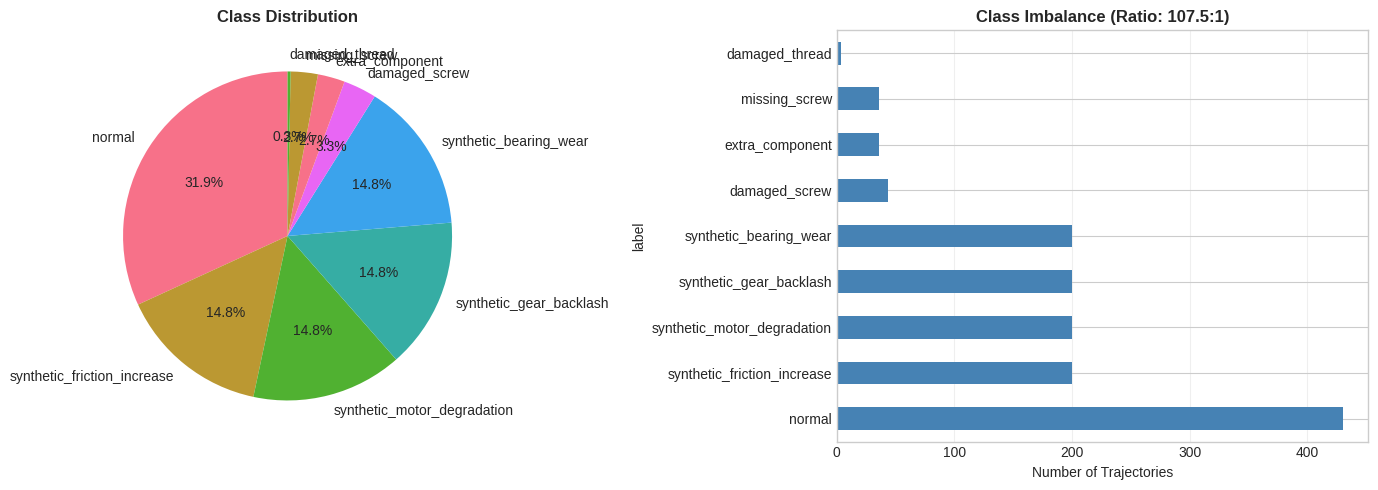


Class Distribution:
  normal                             :  430 (31.85%)
  synthetic_friction_increase        :  200 (14.81%)
  synthetic_motor_degradation        :  200 (14.81%)
  synthetic_gear_backlash            :  200 (14.81%)
  synthetic_bearing_wear             :  200 (14.81%)
  damaged_screw                      :   44 ( 3.26%)
  extra_component                    :   36 ( 2.67%)
  missing_screw                      :   36 ( 2.67%)
  damaged_thread                     :    4 ( 0.30%)

Imbalance Ratio: 107.5:1
  q1_std         : F=  40.080, p=1.3821e-57 ***
  qd1_std        : F=  17.080, p=2.3304e-24 ***
  qd1_max        : F=   5.848, p=2.2899e-07 ***
  i1_mean        : F= 134.872, p=5.6287e-166 ***


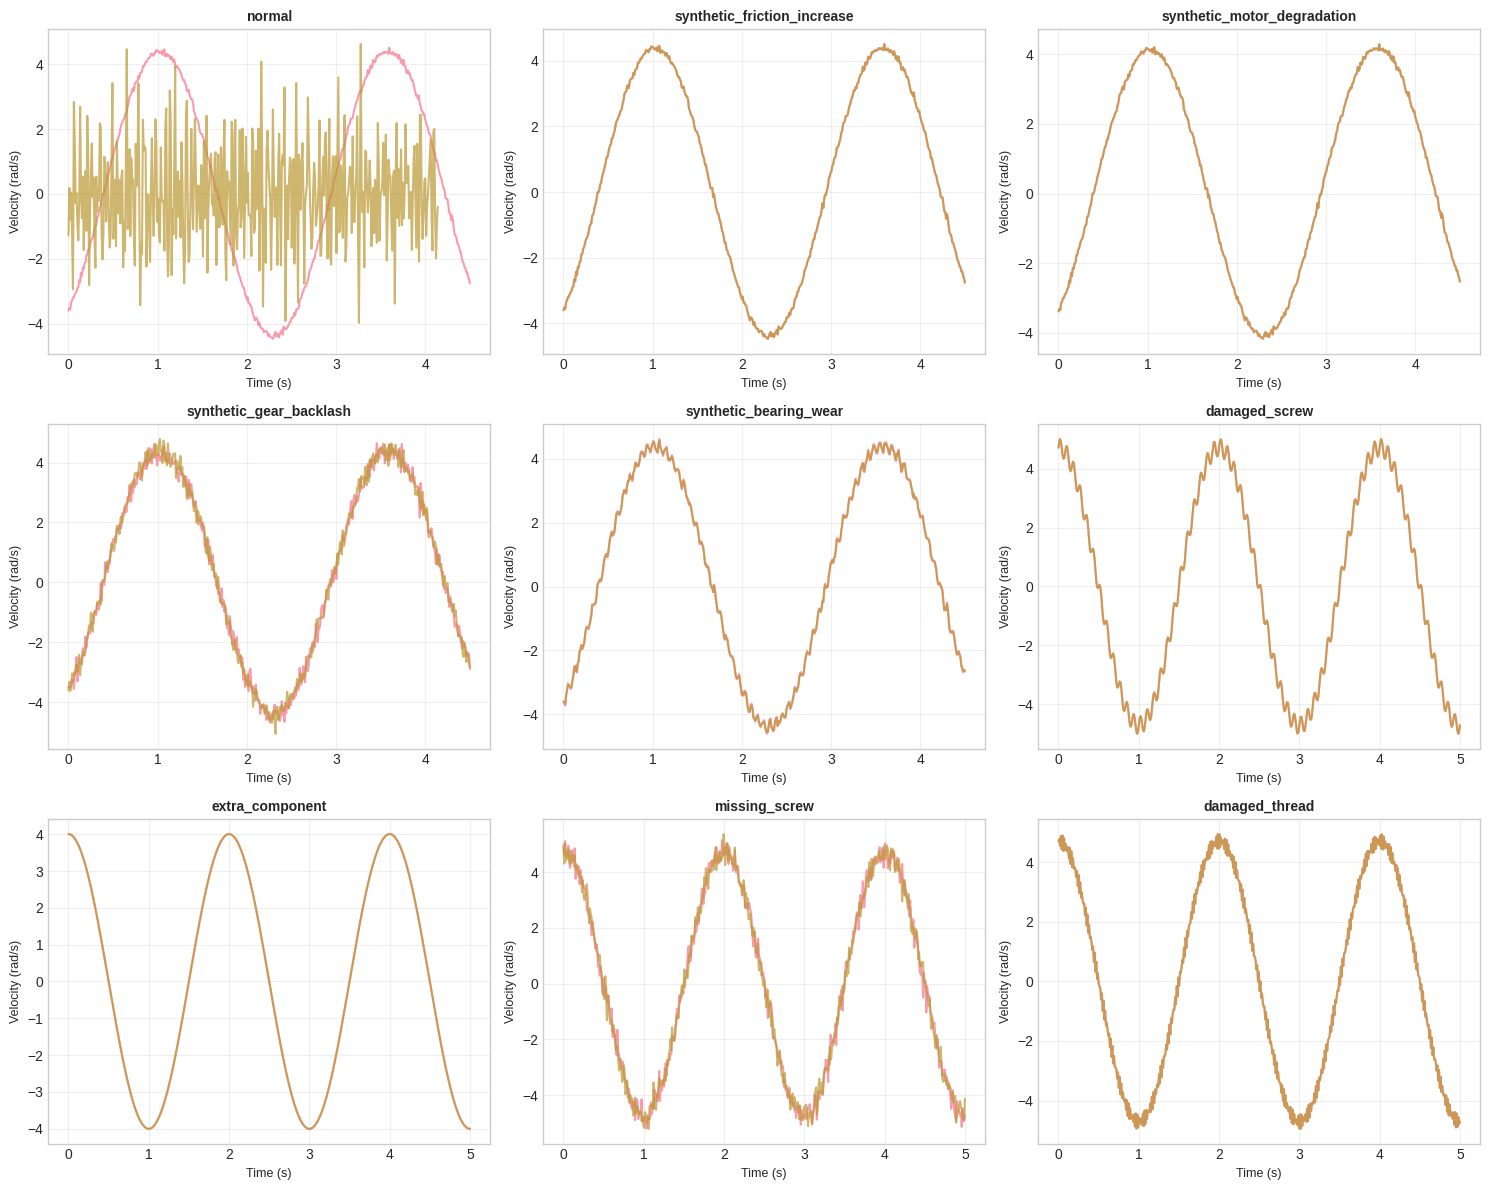

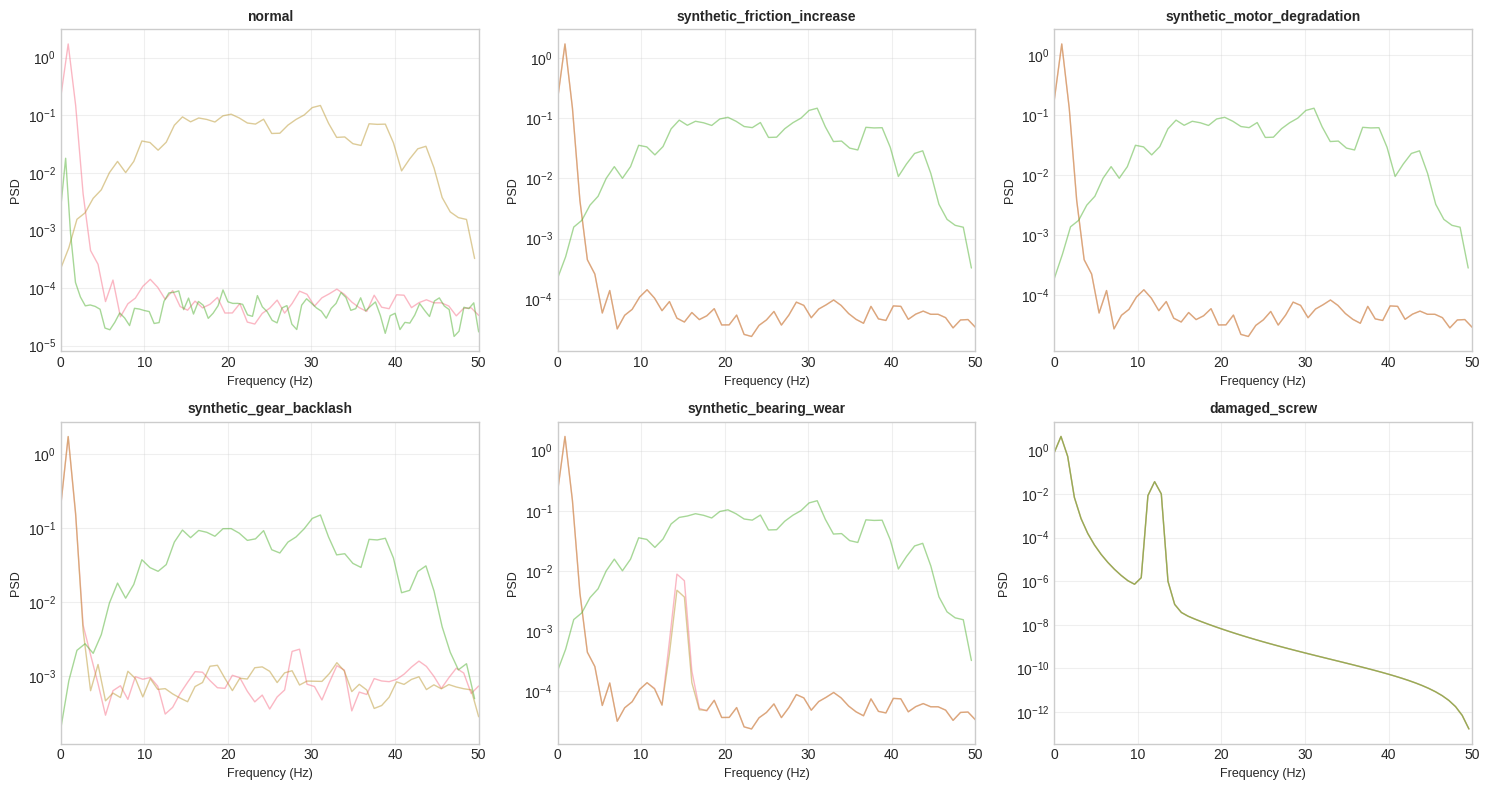

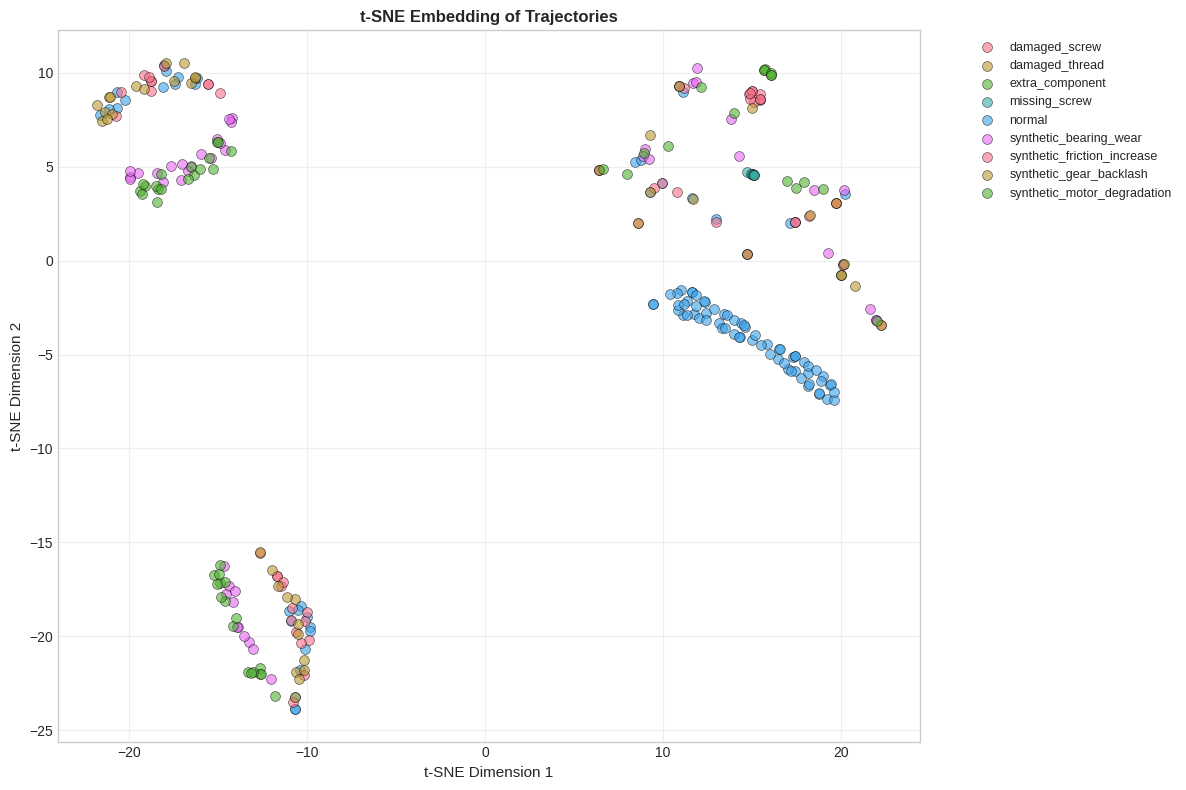

In [2]:
"""
Statistical, temporal, and frequency domain analysis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load data
df = pd.read_pickle('robot_dataset.pkl')

print(f"\nDataset: {len(df):,} records, {df['sample_id'].nunique():,} trajectories")
print(f"Features: {len([c for c in df.columns if c.startswith(('q', 'qd', 'i'))])}")

labels = df.groupby('sample_id')['label'].first()
class_counts = labels.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution', fontsize=12, fontweight='bold')

# Bar chart
class_counts.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_xlabel('Number of Trajectories')
axes[1].set_title(f'Class Imbalance (Ratio: {imbalance_ratio:.1f}:1)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass Distribution:")
for label, count in class_counts.items():
    print(f"  {label:35s}: {count:4d} ({count/len(labels)*100:5.2f}%)")
print(f"\nImbalance Ratio: {imbalance_ratio:.1f}:1")

# Compute trajectory-level statistics
stats_list = []

for sample_id in df['sample_id'].unique():
    traj = df[df['sample_id'] == sample_id]

    stats_list.append({
        'sample_id': sample_id,
        'label': traj['label'].iloc[0],
        'source': traj['source'].iloc[0],
        'q1_mean': traj['q1'].mean(),
        'q1_std': traj['q1'].std(),
        'qd1_mean': traj['qd1'].mean(),
        'qd1_std': traj['qd1'].std(),
        'qd1_max': traj['qd1'].abs().max(),
        'i1_mean': traj['i1'].mean(),
    })

stats_df = pd.DataFrame(stats_list)

# ANOVA tests

for feature in ['q1_std', 'qd1_std', 'qd1_max', 'i1_mean']:
    groups = [stats_df[stats_df['label'] == label][feature].values for label in class_counts.index]
    f_stat, p_value = stats.f_oneway(*groups)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {feature:15s}: F={f_stat:8.3f}, p={p_value:.4e} {sig}")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

unique_labels = class_counts.index[:9]

for idx, label in enumerate(unique_labels):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    sample_ids = labels[labels == label].index[:2]
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        ax.plot(traj['time'], traj['qd1'], alpha=0.7, linewidth=1.5)

    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Velocity (rad/s)', fontsize=9)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory_samples.png', dpi=150, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, label in enumerate(unique_labels[:6]):
    ax = axes[idx]

    sample_ids = labels[labels == label].index[:3]

    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        signal_data = traj['qd1'].values

        fs = 100.0  # 100 Hz
        freqs, psd = welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)//4))

        ax.semilogy(freqs, psd, alpha=0.5, linewidth=1.0)

    ax.set_xlabel('Frequency (Hz)', fontsize=9)
    ax.set_ylabel('PSD', fontsize=9)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_xlim([0, 50])
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('frequency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample for t-SNE (computational efficiency)
sample_ids = df['sample_id'].unique()
if len(sample_ids) > 300:
    sample_ids = np.random.choice(sample_ids, 300, replace=False)

tsne_features = []
tsne_labels = []

for sid in sample_ids:
    traj = df[df['sample_id'] == sid]
    tsne_features.append([
        traj['qd1'].mean(),
        traj['qd1'].std(),
        traj['q1'].std(),
        traj['i1'].mean()
    ])
    tsne_labels.append(traj['label'].iloc[0])

X_tsne_input = StandardScaler().fit_transform(tsne_features)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne_input)//4))
X_tsne = tsne.fit_transform(X_tsne_input)

# Plot
plt.figure(figsize=(12, 8))
for label in np.unique(tsne_labels):
    mask = np.array(tsne_labels) == label
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               label=label, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

plt.xlabel('t-SNE Dimension 1', fontsize=11)
plt.ylabel('t-SNE Dimension 2', fontsize=11)
plt.title('t-SNE Embedding of Trajectories', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_embedding.png', dpi=150, bbox_inches='tight')
plt.show()

# Save stats for later use
stats_df.to_pickle('trajectory_statistics.pkl')


## Feature extraction

In [3]:
"""
Extract 287 features from kinematic trajectories
Statistical, Frequency, Wavelet, Temporal, Cross-joint features
"""

import numpy as np
import pandas as pd
from scipy import stats, signal
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import pywt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_pickle('robot_dataset.pkl')

print(f"\nDataset: {df['sample_id'].nunique()} trajectories")

def extract_statistical_features(signal_data, prefix=''):
    """Statistical features: mean, std, skewness, kurtosis, range, RMS, etc."""
    return {
        f'{prefix}_mean': np.mean(signal_data),
        f'{prefix}_median': np.median(signal_data),
        f'{prefix}_std': np.std(signal_data),
        f'{prefix}_var': np.var(signal_data),
        f'{prefix}_range': np.ptp(signal_data),
        f'{prefix}_iqr': np.percentile(signal_data, 75) - np.percentile(signal_data, 25),
        f'{prefix}_skewness': stats.skew(signal_data),
        f'{prefix}_kurtosis': stats.kurtosis(signal_data),
        f'{prefix}_min': np.min(signal_data),
        f'{prefix}_max': np.max(signal_data),
        f'{prefix}_absmax': np.max(np.abs(signal_data)),
        f'{prefix}_rms': np.sqrt(np.mean(signal_data**2)),
        f'{prefix}_crest_factor': np.max(np.abs(signal_data)) / (np.sqrt(np.mean(signal_data**2)) + 1e-10),
        f'{prefix}_shape_factor': np.sqrt(np.mean(signal_data**2)) / (np.mean(np.abs(signal_data)) + 1e-10)
    }

def extract_frequency_features(signal_data, sampling_rate, prefix=''):
    """Frequency domain features: FFT, PSD, spectral statistics."""
    n = len(signal_data)
    if n < 4:
        return {f'{prefix}_freq_{k}': 0 for k in range(15)}

    # FFT
    fft_vals = np.abs(fft(signal_data))[:n//2]
    freqs = fftfreq(n, 1/sampling_rate)[:n//2]

    # PSD
    if n >= 256:
        freqs_psd, psd = welch(signal_data, fs=sampling_rate, nperseg=min(256, n//4))
    else:
        psd = fft_vals ** 2
        freqs_psd = freqs

    # Dominant frequency
    dominant_idx = np.argmax(fft_vals) if len(fft_vals) > 0 else 0

    # Spectral statistics
    psd_norm = psd / (np.sum(psd) + 1e-10)
    psd_safe = psd_norm[psd_norm > 0]

    # Band powers (0-10, 10-30, 30-50 Hz)
    band_powers = []
    for f_low, f_high in [(0, 10), (10, 30), (30, 50)]:
        mask = (freqs_psd >= f_low) & (freqs_psd < f_high)
        band_powers.append(np.sum(psd[mask]) if np.any(mask) else 0)

    total_power = np.sum(psd)

    return {
        f'{prefix}_dominant_freq': freqs[dominant_idx] if len(freqs) > 0 else 0,
        f'{prefix}_dominant_magnitude': fft_vals[dominant_idx] if len(fft_vals) > 0 else 0,
        f'{prefix}_spectral_centroid': np.sum(freqs_psd * psd_norm),
        f'{prefix}_spectral_spread': np.sqrt(np.sum(((freqs_psd - np.sum(freqs_psd * psd_norm))**2) * psd_norm)),
        f'{prefix}_spectral_entropy': -np.sum(psd_safe * np.log2(psd_safe)) if len(psd_safe) > 0 else 0,
        f'{prefix}_spectral_skewness': stats.skew(psd),
        f'{prefix}_spectral_kurtosis': stats.kurtosis(psd),
        f'{prefix}_power_low': band_powers[0],
        f'{prefix}_power_mid': band_powers[1],
        f'{prefix}_power_high': band_powers[2],
        f'{prefix}_total_power': total_power,
        f'{prefix}_ratio_low': band_powers[0] / (total_power + 1e-10),
        f'{prefix}_ratio_mid': band_powers[1] / (total_power + 1e-10),
        f'{prefix}_ratio_high': band_powers[2] / (total_power + 1e-10),
    }

def extract_wavelet_features(signal_data, prefix='', wavelet='db4', level=4):
    """Wavelet decomposition features."""
    if len(signal_data) < 2**level:
        signal_data = np.pad(signal_data, (0, 2**level - len(signal_data)), mode='edge')

    features = {}
    try:
        coeffs = pywt.wavedec(signal_data, wavelet, level=level)

        for i, coef in enumerate(coeffs):
            level_name = f'a{i}' if i == 0 else f'd{i}'
            features[f'{prefix}_wavelet_{level_name}_energy'] = np.sum(coef**2)
            features[f'{prefix}_wavelet_{level_name}_mean'] = np.mean(coef)
            features[f'{prefix}_wavelet_{level_name}_std'] = np.std(coef)
            features[f'{prefix}_wavelet_{level_name}_max'] = np.max(np.abs(coef))
    except:
        for i in range(level + 1):
            level_name = f'a{i}' if i == 0 else f'd{i}'
            features[f'{prefix}_wavelet_{level_name}_energy'] = 0
            features[f'{prefix}_wavelet_{level_name}_mean'] = 0
            features[f'{prefix}_wavelet_{level_name}_std'] = 0
            features[f'{prefix}_wavelet_{level_name}_max'] = 0

    return features

def extract_temporal_features(signal_data, time_data, prefix=''):
    """Temporal features: autocorrelation, trends, peaks."""
    n = len(signal_data)

    # Autocorrelation
    autocorr = np.correlate(signal_data - np.mean(signal_data),
                           signal_data - np.mean(signal_data), mode='full')
    autocorr = autocorr[len(autocorr)//2:] / (autocorr[len(autocorr)//2] + 1e-10)

    # Trend
    slope = 0
    if len(time_data) > 1:
        slope, _ = np.polyfit(time_data, signal_data, 1)

    # Peaks
    peaks, _ = signal.find_peaks(signal_data)

    features = {}
    for lag in [1, 5, 10, 25]:
        features[f'{prefix}_autocorr_lag{lag}'] = autocorr[lag] if lag < len(autocorr) else 0

    features[f'{prefix}_trend_slope'] = slope
    features[f'{prefix}_zero_crossing_rate'] = np.sum(np.diff(np.sign(signal_data)) != 0) / len(signal_data)
    features[f'{prefix}_peak_count'] = len(peaks)
    features[f'{prefix}_peak_rate'] = len(peaks) / len(signal_data)

    return features

def extract_cross_joint_features(joint_signals):
    """Cross-joint coordination features."""
    features = {}

    # Pairwise correlations
    n_joints = min(3, len(joint_signals))
    for i in range(n_joints):
        for j in range(i+1, n_joints):
            corr = np.corrcoef(joint_signals[i], joint_signals[j])[0, 1]
            features[f'cross_corr_j{i+1}_j{j+1}'] = corr if not np.isnan(corr) else 0

    # Coordination metrics
    joint_means = [np.mean(js) for js in joint_signals]
    joint_stds = [np.std(js) for js in joint_signals]

    features['cross_coordination_mean_std'] = np.std(joint_means)
    features['cross_coordination_std_std'] = np.std(joint_stds)

    return features

def extract_all_features(trajectory_df, sample_id):
    """Extract all 287 features for a single trajectory."""
    features = {
        'sample_id': sample_id,
        'label': trajectory_df['label'].iloc[0],
        'source': trajectory_df['source'].iloc[0],
        'duration': trajectory_df['time'].max() - trajectory_df['time'].min(),
        'n_samples': len(trajectory_df)
    }

    time_data = trajectory_df['time'].values
    sampling_rate = 100.0  # Hz

    # Extract for each joint
    joints = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3']

    for joint in joints:
        if joint not in trajectory_df.columns:
            continue

        signal_data = trajectory_df[joint].values

        # Statistical
        features.update(extract_statistical_features(signal_data, prefix=joint))

        # Frequency
        features.update(extract_frequency_features(signal_data, sampling_rate, prefix=joint))

        # Wavelet (for velocities only)
        if joint.startswith('qd'):
            features.update(extract_wavelet_features(signal_data, prefix=joint))

        # Temporal
        features.update(extract_temporal_features(signal_data, time_data, prefix=joint))

    # Cross-joint
    velocity_signals = [trajectory_df[f'qd{i}'].values for i in range(1, 4)
                       if f'qd{i}' in trajectory_df.columns]
    if len(velocity_signals) >= 2:
        features.update(extract_cross_joint_features(velocity_signals))

    return features

print("\nExtracting features from trajectories...")

feature_list = []
for sample_id in tqdm(df['sample_id'].unique(), desc="Feature Extraction"):
    trajectory = df[df['sample_id'] == sample_id]
    features = extract_all_features(trajectory, sample_id)
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
features_df = features_df.fillna(0)  # Handle any NaN

# Summary
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]

print(f"\n Feature extraction complete!")
print(f"  Trajectories: {len(features_df)}")
print(f"  Features per trajectory: {len(feature_cols)}")

print(f"\nFeature breakdown:")
stat_features = [c for c in feature_cols if any(x in c for x in ['mean', 'std', 'skew', 'kurt', 'rms'])]
freq_features = [c for c in feature_cols if 'freq' in c or 'spectral' in c or 'power' in c]
wavelet_features = [c for c in feature_cols if 'wavelet' in c]
temporal_features = [c for c in feature_cols if 'autocorr' in c or 'trend' in c or 'peak' in c]
cross_features = [c for c in feature_cols if 'cross' in c]

print(f"  Statistical: {len(stat_features)}")
print(f"  Frequency:   {len(freq_features)}")
print(f"  Wavelet:     {len(wavelet_features)}")
print(f"  Temporal:    {len(temporal_features)}")
print(f"  Cross-joint: {len(cross_features)}")

# Save
features_df.to_pickle('robot_features.pkl')
features_df.head(100).to_csv('robot_features_sample.csv', index=False)

print(f"Saved: robot_features.pkl")
print(f"Saved: robot_features_sample.csv")



Dataset: 1350 trajectories

Extracting features from trajectories...


Feature Extraction:   0%|          | 0/1350 [00:00<?, ?it/s]


 Feature extraction complete!
  Trajectories: 1350
  Features per trajectory: 281

Feature breakdown:
  Statistical: 74
  Frequency:   60
  Wavelet:     60
  Temporal:    42
  Cross-joint: 11
Saved: robot_features.pkl
Saved: robot_features_sample.csv


## Unsupervised Anomaly detection


Data split:
  Training (normal): 430
  Testing (anomaly): 920
METHOD 1: ISOLATION FOREST

Results:
  F1-Score:  0.6667
  Precision: 1.0000
  Recall:    0.5000
METHOD 2: LSTM AUTOENCODER

Training LSTM Autoencoder (50 epochs)...
  Epoch 10: Loss = 0.066159
  Epoch 20: Loss = 0.030296
  Epoch 30: Loss = 0.026135
  Epoch 40: Loss = 0.023472
  Epoch 50: Loss = 0.020901

Results:
  F1-Score:  0.7024
  Precision: 1.0000
  Recall:    0.5413


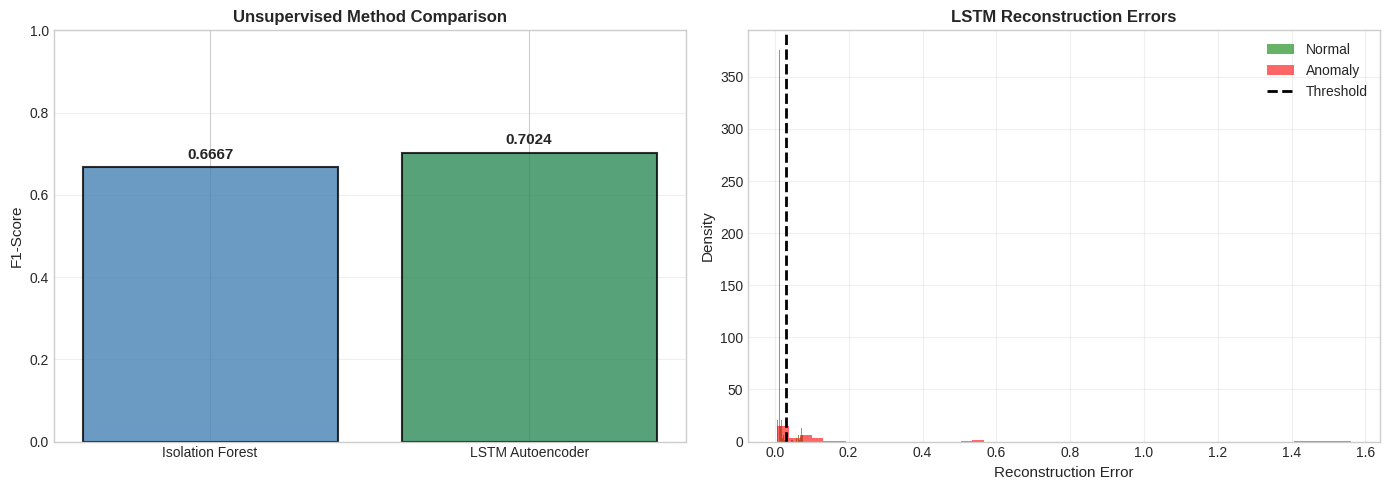


Best Method: LSTM Autoencoder
Best F1: 0.7024


In [4]:
"""
Unsupervised Anomaly Detection
Isolation Forest + LSTM Autoencoder
Train on normal data only, detect anomalies
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load features for Isolation Forest
features_df = pd.read_pickle('robot_features.pkl')
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples', 'sampling_rate']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]

# Remove constants
feature_cols = [c for c in feature_cols if features_df[c].std() > 0]
features_df[feature_cols] = features_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# Load sequences for LSTM
df = pd.read_pickle('robot_dataset.pkl')

# Split normal vs anomaly
normal_mask = features_df['label'] == 'normal'

X_train_features = features_df[normal_mask][feature_cols].values
X_test_features = features_df[~normal_mask][feature_cols].values
y_test = (features_df[~normal_mask]['label'] != 'normal').astype(int).values
y_test_labels = features_df[~normal_mask]['label'].values

print(f"\nData split:")
print(f"  Training (normal): {len(X_train_features)}")
print(f"  Testing (anomaly): {len(X_test_features)}")

print("METHOD 1: ISOLATION FOREST")


# Scale features
scaler_if = StandardScaler()
X_train_scaled = scaler_if.fit_transform(X_train_features)
X_test_scaled = scaler_if.transform(X_test_features)

# Train
model_if = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
model_if.fit(X_train_scaled)

# Predict
y_pred_if = model_if.predict(X_test_scaled)
y_pred_binary_if = (y_pred_if == -1).astype(int)
anomaly_scores_if = model_if.decision_function(X_test_scaled)

# Optimize threshold
best_f1_if = 0
for percentile in [10, 20, 30, 40, 50]:
    threshold = np.percentile(anomaly_scores_if, percentile)
    y_pred_thresh = (anomaly_scores_if < threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1_if:
        best_f1_if = f1
        best_pred_if = y_pred_thresh

f1_if = f1_score(y_test, best_pred_if)
precision_if = precision_score(y_test, best_pred_if, zero_division=0)
recall_if = recall_score(y_test, best_pred_if)

print(f"\nResults:")
print(f"  F1-Score:  {f1_if:.4f}")
print(f"  Precision: {precision_if:.4f}")
print(f"  Recall:    {recall_if:.4f}")

print("METHOD 2: LSTM AUTOENCODER")

# Prepare sequences
def extract_sequences(sample_ids, df):
    sequences = []
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        features = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6']
        seq = traj[features].values

        if len(seq) > 500:
            seq = seq[:500]
        elif len(seq) < 500:
            seq = np.vstack([seq, np.zeros((500 - len(seq), len(features)))])

        sequences.append(seq)
    return np.array(sequences)

normal_ids = features_df[normal_mask]['sample_id'].values
anomaly_ids = features_df[~normal_mask]['sample_id'].values

X_train_seq = extract_sequences(normal_ids, df)
X_test_seq = extract_sequences(anomaly_ids, df)

# Normalize
scaler_lstm = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[2])
X_train_seq_norm = scaler_lstm.fit_transform(X_train_flat).reshape(X_train_seq.shape)
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[2])
X_test_seq_norm = scaler_lstm.transform(X_test_flat).reshape(X_test_seq.shape)

# Model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, 2, batch_first=True, dropout=0.3, bidirectional=True)
        self.decoder = nn.LSTM(hidden_dim*2, hidden_dim, 2, batch_first=True, dropout=0.3)
        self.output = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded, (h, c) = self.encoder(x)
        decoded, _ = self.decoder(encoded)
        return self.output(decoded)

model_lstm = LSTMAutoencoder(input_dim=12, hidden_dim=128).to(device)

# Train
train_loader = DataLoader(torch.FloatTensor(X_train_seq_norm), batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print(f"\nTraining LSTM Autoencoder (50 epochs)...")

for epoch in range(50):
    model_lstm.train()
    epoch_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        reconstructed = model_lstm(batch)
        loss = criterion(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.6f}")

# Evaluate
model_lstm.eval()
with torch.no_grad():
    train_recon = model_lstm(torch.FloatTensor(X_train_seq_norm).to(device))
    test_recon = model_lstm(torch.FloatTensor(X_test_seq_norm).to(device))

train_errors = ((torch.FloatTensor(X_train_seq_norm).to(device) - train_recon)**2).mean(dim=(1,2)).cpu().numpy()
test_errors = ((torch.FloatTensor(X_test_seq_norm).to(device) - test_recon)**2).mean(dim=(1,2)).cpu().numpy()

threshold_lstm = np.percentile(train_errors, 90)
y_pred_lstm = (test_errors > threshold_lstm).astype(int)

f1_lstm = f1_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, zero_division=0)
recall_lstm = recall_score(y_test, y_pred_lstm)

print(f"\nResults:")
print(f"  F1-Score:  {f1_lstm:.4f}")
print(f"  Precision: {precision_lstm:.4f}")
print(f"  Recall:    {recall_lstm:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Method comparison
methods = ['Isolation Forest', 'LSTM Autoencoder']
f1_scores = [f1_if, f1_lstm]
colors = ['steelblue', 'seagreen']

axes[0].bar(methods, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('F1-Score', fontsize=11)
axes[0].set_title('Unsupervised Method Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for i, (method, score) in enumerate(zip(methods, f1_scores)):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

# Reconstruction error distribution (LSTM)
axes[1].hist(train_errors, bins=50, alpha=0.6, label='Normal', color='green', density=True)
axes[1].hist(test_errors, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
axes[1].axvline(threshold_lstm, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_xlabel('Reconstruction Error', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('LSTM Reconstruction Errors', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('track1_unsupervised_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_track1 = {
    'isolation_forest': {'f1': f1_if, 'precision': precision_if, 'recall': recall_if},
    'lstm_autoencoder': {'f1': f1_lstm, 'precision': precision_lstm, 'recall': recall_lstm}
}

pd.DataFrame(results_track1).to_csv('track1_results.csv')

print(f"\nBest Method: {'Isolation Forest' if f1_if > f1_lstm else 'LSTM Autoencoder'}")
print(f"Best F1: {max(f1_if, f1_lstm):.4f}")


## Supervised Classification


 Dataset: 1350 samples, 281 features
  Train: 1080, Test: 270
  After SMOTE: 3096 samples
RANDOM FOREST

Accuracy: 0.9481
Balanced Accuracy: 0.9789
Macro F1: 0.9731
XGBOOST

Accuracy: 0.9667
Balanced Accuracy: 0.9839
Macro F1: 0.9821


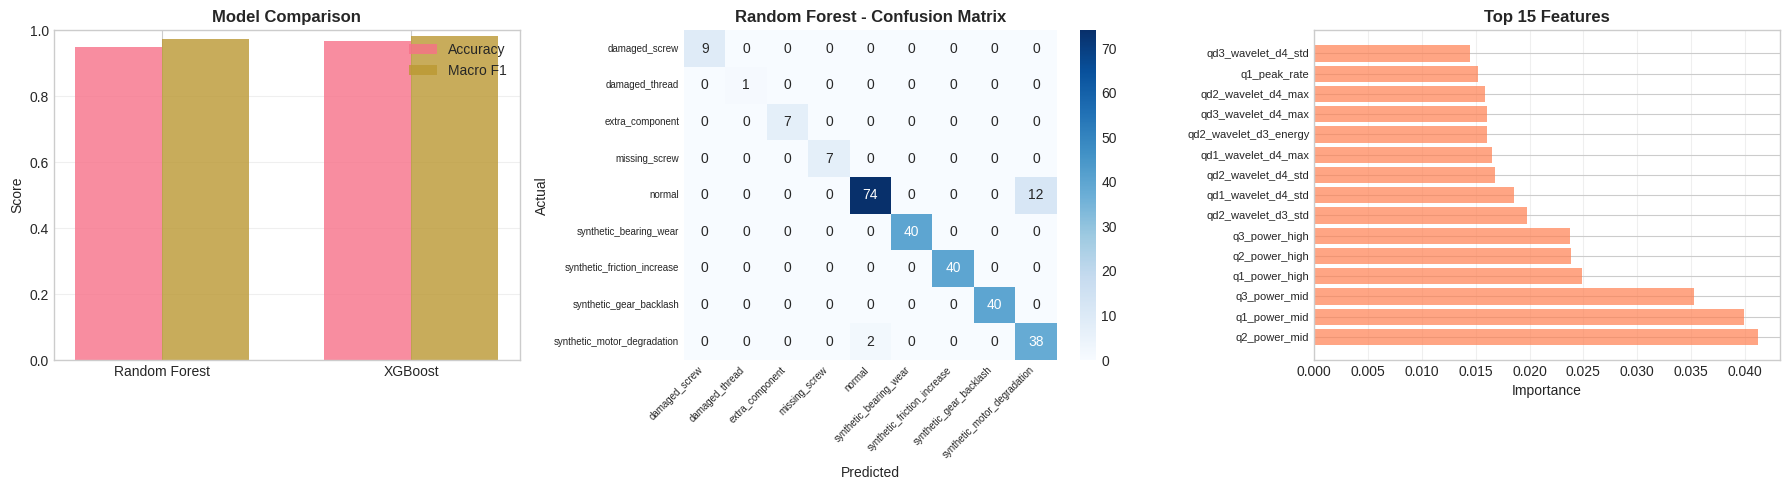


Best Model: XGBoost
Best Accuracy: 0.9667
Best Macro F1: 0.9821


In [5]:
"""
Supervised Classification
Random Forest + XGBoost with SMOTE for class imbalance
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, balanced_accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

features_df = pd.read_pickle('robot_features.pkl')
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples', 'sampling_rate']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]
feature_cols = [c for c in feature_cols if features_df[c].std() > 0]

features_df[feature_cols] = features_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n Dataset: {len(features_df)} samples, {len(feature_cols)} features")

# Stratified split
X = features_df[feature_cols].values
y = features_df['label'].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"  Train: {len(X_train)}, Test: {len(X_test)}")

# Apply SMOTE
unique, counts = np.unique(y_train, return_counts=True)
k_neighbors = min(5, min(counts) - 1) if min(counts) > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"  After SMOTE: {len(X_train_balanced)} samples")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("RANDOM FOREST")

rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced',
                            random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_balanced)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)

print(f"\nAccuracy: {acc_rf:.4f}")
print(f"Balanced Accuracy: {bal_acc_rf:.4f}")
print(f"Macro F1: {report_rf['macro avg']['f1-score']:.4f}")


print("XGBOOST")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_balanced)
y_test_enc = le.transform(y_test)

classes = np.unique(y_train_enc)
weights = compute_class_weight('balanced', classes=classes, y=y_train_enc)
sample_weights = weights[y_train_enc]

xgb = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                   random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train_enc, sample_weight=sample_weights)

y_pred_xgb = le.inverse_transform(xgb.predict(X_test_scaled))

acc_xgb = accuracy_score(y_test, y_pred_xgb)
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)

print(f"\nAccuracy: {acc_xgb:.4f}")
print(f"Balanced Accuracy: {bal_acc_xgb:.4f}")
print(f"Macro F1: {report_xgb['macro avg']['f1-score']:.4f}")


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model comparison
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [acc_rf, acc_xgb],
    'Macro F1': [report_rf['macro avg']['f1-score'], report_xgb['macro avg']['f1-score']]
})

x_pos = np.arange(len(comparison))
width = 0.35

axes[0].bar(x_pos - width/2, comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison['Macro F1'], width, label='Macro F1', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'])
axes[0].set_ylabel('Score')
axes[0].set_title('Model Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
unique_labels = np.unique(y_test)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=unique_labels, yticklabels=unique_labels)
axes[1].set_title('Random Forest - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=7)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=7)

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

axes[2].barh(range(len(indices)), importances[indices], color='coral', alpha=0.7)
axes[2].set_yticks(range(len(indices)))
axes[2].set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Features', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('track2_supervised_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_track2 = {
    'random_forest': {'accuracy': acc_rf, 'macro_f1': report_rf['macro avg']['f1-score']},
    'xgboost': {'accuracy': acc_xgb, 'macro_f1': report_xgb['macro avg']['f1-score']}
}

pd.DataFrame(results_track2).to_csv('track2_results.csv')


print(f"\nBest Model: {'Random Forest' if acc_rf > acc_xgb else 'XGBoost'}")
print(f"Best Accuracy: {max(acc_rf, acc_xgb):.4f}")
print(f"Best Macro F1: {max(report_rf['macro avg']['f1-score'], report_xgb['macro avg']['f1-score']):.4f}")


## Transfer learning

In [6]:
"""
Transfer Learning
Pre-train on abundant normal data, fine-tune on limited failures
Novel contribution: Knowledge transfer from normal→fault detection
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


df = pd.read_pickle('robot_dataset.pkl')

# Separate normal vs failures
normal_ids = df[df['label'] == 'normal']['sample_id'].unique()
failure_ids = df[df['label'] != 'normal']['sample_id'].unique()

# Split failures: 30% fine-tune, 70% test
np.random.shuffle(failure_ids)
n_finetune = int(len(failure_ids) * 0.3)

finetune_ids = failure_ids[:n_finetune]
test_ids = failure_ids[n_finetune:]

print(f"\nData splits:")
print(f"  Pre-train (normal): {len(normal_ids)}")
print(f"  Fine-tune (failures): {len(finetune_ids)}")
print(f"  Test (held-out): {len(test_ids)}")

# Extract sequences
def extract_sequences(sample_ids):
    sequences, labels = [], []
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        features = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6']
        seq = traj[features].values

        if len(seq) > 500:
            seq = seq[:500]
        elif len(seq) < 500:
            seq = np.vstack([seq, np.zeros((500 - len(seq), len(features)))])

        sequences.append(seq)
        labels.append(traj['label'].iloc[0])

    return np.array(sequences), labels

X_pretrain, _ = extract_sequences(normal_ids)
X_finetune, y_finetune = extract_sequences(finetune_ids)
X_test, y_test = extract_sequences(test_ids)

# Normalize
scaler = StandardScaler()
X_pretrain_norm = scaler.fit_transform(X_pretrain.reshape(-1, 12)).reshape(X_pretrain.shape)
X_finetune_norm = scaler.transform(X_finetune.reshape(-1, 12)).reshape(X_finetune.shape)
X_test_norm = scaler.transform(X_test.reshape(-1, 12)).reshape(X_test.shape)

print(f" Sequences prepared and normalized")

class TransferLSTMClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=128, num_classes=9):
        super().__init__()

        self.encoder = nn.LSTM(input_dim, hidden_dim, 2, batch_first=True,
                              dropout=0.3, bidirectional=True)
        self.decoder = nn.LSTM(hidden_dim*2, hidden_dim, 2, batch_first=True, dropout=0.3)
        self.reconstruction_head = nn.Linear(hidden_dim, input_dim)

        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_dim*2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.mode = 'pretrain'

    def forward(self, x):
        encoded, _ = self.encoder(x)

        if self.mode == 'pretrain':
            decoded, _ = self.decoder(encoded)
            return self.reconstruction_head(decoded)
        else:
            pooled = encoded.mean(dim=1)
            return self.classifier_head(pooled)


print("PHASE 1: PRE-TRAINING ON NORMAL DATA")


model = TransferLSTMClassifier().to(device)
model.mode = 'pretrain'

train_loader = DataLoader(torch.FloatTensor(X_pretrain_norm), batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nPre-training (50 epochs)...")

for epoch in range(50):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.6f}")

torch.save(model.state_dict(), 'pretrained_model.pth')
print(f"Pre-training complete")


print("PHASE 2: FINE-TUNING ON FAILURE DATA")


model.mode = 'finetune'

# Encode labels
le = LabelEncoder()
y_finetune_enc = le.fit_transform(y_finetune)

# Freeze encoder initially
for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.decoder.parameters():
    param.requires_grad = False

finetune_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_finetune_norm), torch.LongTensor(y_finetune_enc)),
    batch_size=16, shuffle=True
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier_head.parameters(), lr=0.0001)

print(f"\nFine-tuning classifier (30 epochs, encoder frozen)...")

for epoch in range(30):
    model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1} complete")

# Unfreeze and final tune
print(f"\nUnfreezing encoder (10 epochs)...")
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(10):
    model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print(f"Fine-tuning complete")

print("EVALUATION")

model.eval()
with torch.no_grad():
    logits = model(torch.FloatTensor(X_test_norm).to(device))
    _, predictions = torch.max(logits, 1)
    y_pred = le.inverse_transform(predictions.cpu().numpy())

acc_transfer = accuracy_score(y_test, y_pred)
report_transfer = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
macro_f1_transfer = report_transfer['macro avg']['f1-score']

print(f"\nTransfer Learning Results:")
print(f"  Accuracy: {acc_transfer:.4f}")
print(f"  Macro F1: {macro_f1_transfer:.4f}")


print("BASELINE: NO TRANSFER LEARNING")

baseline_model = TransferLSTMClassifier(num_classes=len(le.classes_)).to(device)
baseline_model.mode = 'finetune'

optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print(f"\nTraining from scratch (30 epochs)...")

for epoch in range(30):
    baseline_model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = baseline_model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

baseline_model.eval()
with torch.no_grad():
    logits = baseline_model(torch.FloatTensor(X_test_norm).to(device))
    _, predictions = torch.max(logits, 1)
    y_pred_baseline = le.inverse_transform(predictions.cpu().numpy())

acc_baseline = accuracy_score(y_test, y_pred_baseline)
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True, zero_division=0)
macro_f1_baseline = report_baseline['macro avg']['f1-score']

print(f"\nBaseline Results:")
print(f"  Accuracy: {acc_baseline:.4f}")
print(f"  Macro F1: {macro_f1_baseline:.4f}")

improvement = ((macro_f1_transfer - macro_f1_baseline) / macro_f1_baseline * 100) if macro_f1_baseline > 0 else 0

print(f"\n Transfer Learning Improvement: {improvement:+.1f}%")

# Save
results_track3 = {
    'transfer_learning': {'accuracy': acc_transfer, 'macro_f1': macro_f1_transfer},
    'baseline_no_transfer': {'accuracy': acc_baseline, 'macro_f1': macro_f1_baseline}
}

pd.DataFrame(results_track3).to_csv('track3_results.csv')





Data splits:
  Pre-train (normal): 430
  Fine-tune (failures): 276
  Test (held-out): 644
 Sequences prepared and normalized
PHASE 1: PRE-TRAINING ON NORMAL DATA

Pre-training (50 epochs)...
  Epoch 10: Loss = 0.067721
  Epoch 20: Loss = 0.029867
  Epoch 30: Loss = 0.026204
  Epoch 40: Loss = 0.023922
  Epoch 50: Loss = 0.021181
Pre-training complete
PHASE 2: FINE-TUNING ON FAILURE DATA

Fine-tuning classifier (30 epochs, encoder frozen)...
  Epoch 10 complete
  Epoch 20 complete
  Epoch 30 complete

Unfreezing encoder (10 epochs)...
Fine-tuning complete
EVALUATION

Transfer Learning Results:
  Accuracy: 0.3090
  Macro F1: 0.1975
BASELINE: NO TRANSFER LEARNING

Training from scratch (30 epochs)...

Baseline Results:
  Accuracy: 0.5699
  Macro F1: 0.5936

 Transfer Learning Improvement: -66.7%


In [9]:
# Workaround for sklearn dependency issue
import os
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'

!pip install aursad

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post12-py3-none-any.whl size=2179 sha256=c31f0cd7d7906dc1ce8135d66b8b2c2a3ace4bc914f279866c9c4bea09f7cd36
  Stored in directory: /root/.cache/pip/wheels/bb/9a/b9/bb720079a088061ea32a0de4fa3ed0b495d7a929efcd80b450
Successfully built sklearn


# AURSAD

## Load aursad data

In [11]:
import sys
!{sys.executable} -m pip show aursad
from google.colab import drive
drive.mount('/content/drive')

import importlib
# importlib.reload(aursad)
import aursad
import numpy as np

data_path = '/content/drive/MyDrive/Colab Notebooks/csml/data/AURSAD.h5'

print(f"Loading from: {data_path}")

train_x, train_y, test_x, test_y = aursad.get_dataset_numpy(
    path=data_path,
    onehot_labels=False,
    pad_data=True,
    train_size=0.8,
    subsample_data=False,
    standardize=False,
    random_state=42
)

print(f"Loaded!")
print(f"  Train: {train_x.shape}")
print(f"  Test: {test_x.shape}")

Name: aursad
Version: 0.2.4
Summary: Accompanying library to the AURSAD dataset
Home-page: https://github.com/CptPirx/robo-package
Author: Błażej Leporowski
Author-email: bleporowski@outlook.com
License: UNKNOWN
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, pandas, sklearn, tensorflow, tqdm
Required-by: 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading from: /content/drive/MyDrive/Colab Notebooks/csml/data/AURSAD.h5
Loaded data
Filtering samples
There are 4091 samples in total.
The types and counts of different labels : 
 {np.int64(5): 2049, np.int64(0): 1420, np.int64(1): 221, np.int64(2): 183, np.int64(3): 218}
The types and counts of different labels as percentage of the total data : 
 {np.int64(5): np.float64(0.5), np.int64(0): np.float64(0.35), np.int64(1): np.float64(0.05), np.int64(2): np.float64(0.04), np.int64(3): np.float64(0.05)}


Padding data: 100%|██████████| 4091/4091 [01:10<00:00, 57.85it/s]


Loaded!
  Train: (3272, 3795, 125)
  Test: (819, 3795, 125)


## Convert AURSAD data to dataframe

In [12]:
"""
Convert AURSAD to DataFrame Format (Memory Efficient)
"""

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

print(f"Original AURSAD size:")
print(f"  Train: {train_x.shape}")
print(f"  Test: {test_x.shape}")

SUBSAMPLE_FACTOR = 8  # Take every 8th timestep

train_x_sub = train_x[:, ::SUBSAMPLE_FACTOR, :]  # Every 8th timestep
test_x_sub = test_x[:, ::SUBSAMPLE_FACTOR, :]

print(f"Subsampling every {SUBSAMPLE_FACTOR} timesteps:")
print(f"  Before: {train_x.shape[1]} timesteps")
print(f"  After: {train_x_sub.shape[1]} timesteps")
print(f"  Effective sampling rate: {100/SUBSAMPLE_FACTOR:.1f} Hz")

# Clear original data
del train_x, test_x
gc.collect()

# AURSAD has 125 features total
# First 18 are robot joints: q1-q6 (0-5), qd1-qd6 (6-11), i1-i6 (12-17)
# Rest are screwdriver sensors, forces, etc.

print(f"Original features: {train_x_sub.shape[2]}")
print(f"Selecting only robot joint features (first 18):")
print(f"  Positions: q1-q6 (indices 0-5)")
print(f"  Velocities: qd1-qd6 (indices 6-11)")
print(f"  Currents: i1-i6 (indices 12-17)")

# Select only first 18 features
train_x_robot = train_x_sub[:, :, :18]
test_x_robot = test_x_sub[:, :, :18]

print(f"After selection:")
print(f"  Train: {train_x_robot.shape}")
print(f"  Test: {test_x_robot.shape}")

# Clear subsampled data
del train_x_sub, test_x_sub
gc.collect()

label_map = {
    0: 'normal',
    1: 'damaged_screw',
    2: 'extra_component',
    3: 'missing_screw',
    4: 'damaged_thread',
    5: 'loosening_motion'
}

BATCH_SIZE = 50  # Process 50 samples at a time
all_data = []

all_samples = np.vstack([train_x_robot, test_x_robot])
all_labels = np.concatenate([train_y, test_y])

n_total = len(all_samples)
n_batches = (n_total + BATCH_SIZE - 1) // BATCH_SIZE

print(f"\nProcessing {n_total} samples in {n_batches} batches...")

for batch_idx in tqdm(range(n_batches), desc="Converting to DataFrame"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, n_total)

    for local_idx in range(start_idx, end_idx):
        sample = all_samples[local_idx]
        label = label_map.get(all_labels[local_idx], 'unknown')
        sample_id = local_idx

        n_timesteps = sample.shape[0]
        time = np.arange(n_timesteps) / (100 / SUBSAMPLE_FACTOR)

        # Create rows for this sample
        for t_idx in range(n_timesteps):
            row = {
                'sample_id': sample_id,
                'time': time[t_idx],
                'label': label,
                'source': 'aursad_real'
            }

            # Positions
            for j in range(6):
                row[f'q{j+1}'] = sample[t_idx, j]

            # Velocities
            for j in range(6):
                row[f'qd{j+1}'] = sample[t_idx, 6+j]

            # Currents
            for j in range(6):
                row[f'i{j+1}'] = sample[t_idx, 12+j]

            all_data.append(row)

    # Periodic garbage collection
    if (batch_idx + 1) % 10 == 0:
        gc.collect()

print(f"\nCreating final DataFrame...")
df = pd.DataFrame(all_data)

# Clean up
del all_data, all_samples, train_x_robot, test_x_robot
gc.collect()

print(f"  Records: {len(df):,}")
print(f"  Trajectories: {df['sample_id'].nunique()}")


labels = df.groupby('sample_id')['label'].first()
class_counts = labels.value_counts()

print(f"\nTotal: {len(labels)} real UR3 robot trajectories")
print(f"\nClass distribution:")
for label, count in class_counts.items():
    pct = count / len(labels) * 100
    print(f"  {label:25s}: {count:4d} ({pct:5.2f}%)")

# Save
df.to_pickle('robot_dataset_aursad.pkl')
print(f"Saved: robot_dataset_aursad.pkl")

Original AURSAD size:
  Train: (3272, 3795, 125)
  Test: (819, 3795, 125)
Subsampling every 8 timesteps:
  Before: 3795 timesteps
  After: 475 timesteps
  Effective sampling rate: 12.5 Hz
Original features: 125
Selecting only robot joint features (first 18):
  Positions: q1-q6 (indices 0-5)
  Velocities: qd1-qd6 (indices 6-11)
  Currents: i1-i6 (indices 12-17)
After selection:
  Train: (3272, 475, 18)
  Test: (819, 475, 18)

Processing 4091 samples in 82 batches...


Converting to DataFrame:   0%|          | 0/82 [00:00<?, ?it/s]


Creating final DataFrame...
  Records: 1,943,225
  Trajectories: 4091

Total: 4091 real UR3 robot trajectories

Class distribution:
  loosening_motion         : 2049 (50.09%)
  normal                   : 1420 (34.71%)
  damaged_screw            :  221 ( 5.40%)
  missing_screw            :  218 ( 5.33%)
  extra_component          :  183 ( 4.47%)
Saved: robot_dataset_aursad.pkl


## Statistical, temporal, and frequency domain analysis


Dataset: 1,943,225 records, 4,091 trajectories
Features: 18


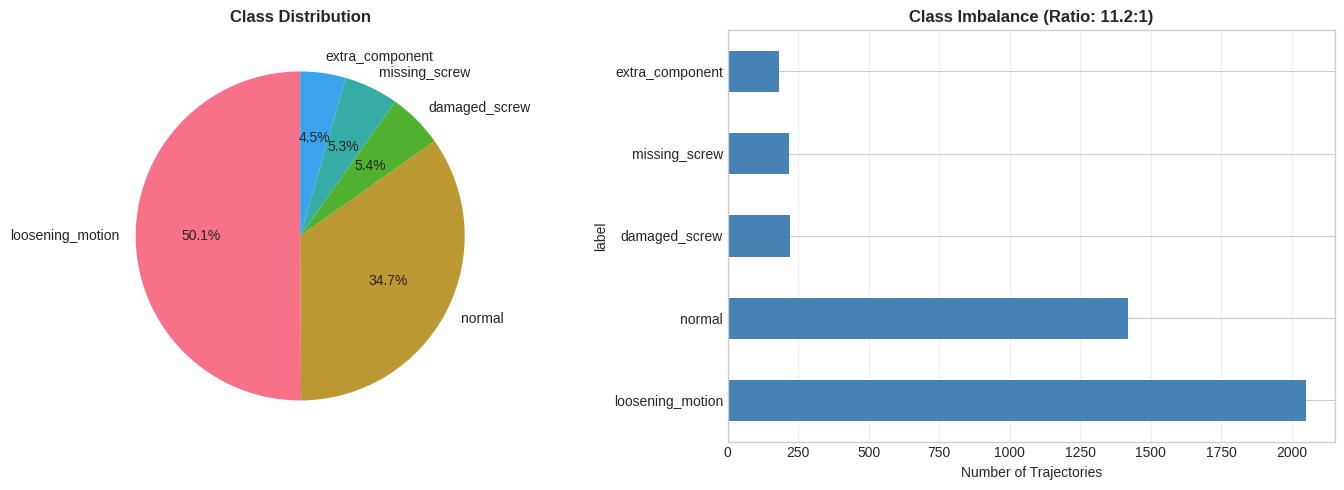


Class Distribution:
  loosening_motion                   : 2049 (50.09%)
  normal                             : 1420 (34.71%)
  damaged_screw                      :  221 ( 5.40%)
  missing_screw                      :  218 ( 5.33%)
  extra_component                    :  183 ( 4.47%)

Imbalance Ratio: 11.2:1
  q1_std         : F=   5.878, p=1.0284e-04 ***
  qd1_std        : F=   5.047, p=4.6791e-04 ***
  qd1_max        : F=   6.448, p=3.6063e-05 ***
  i1_mean        : F=   1.064, p=3.7240e-01 ns


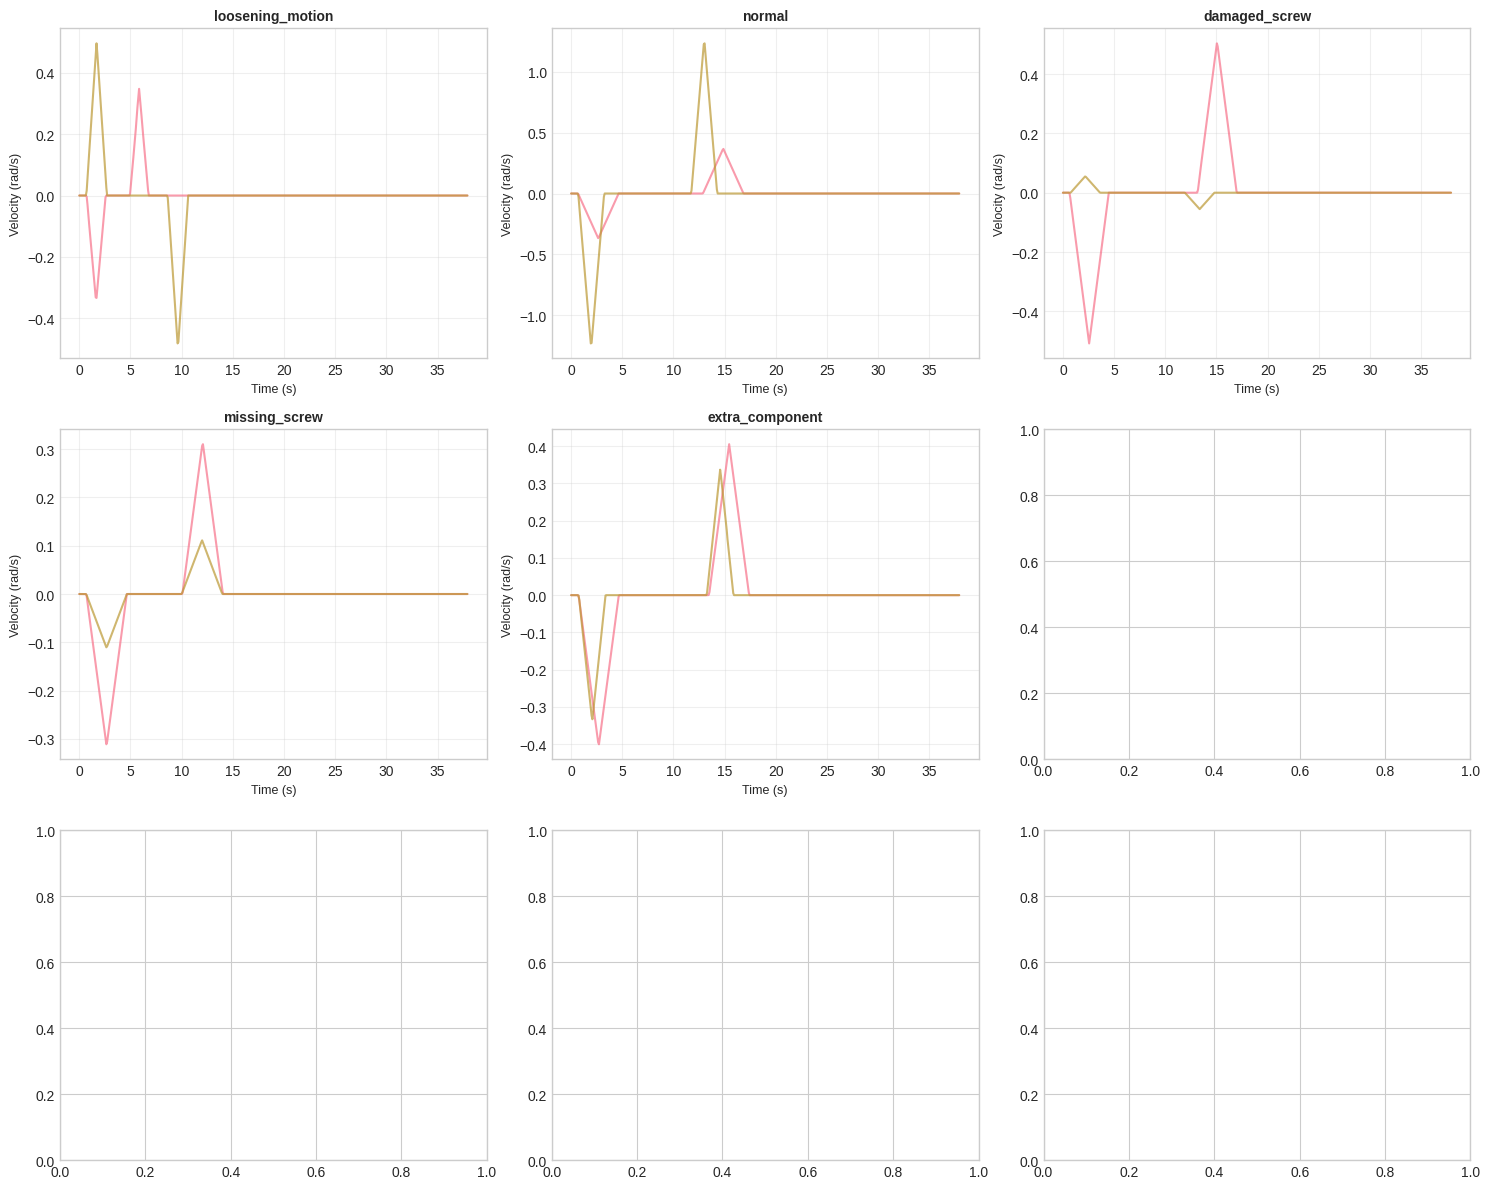

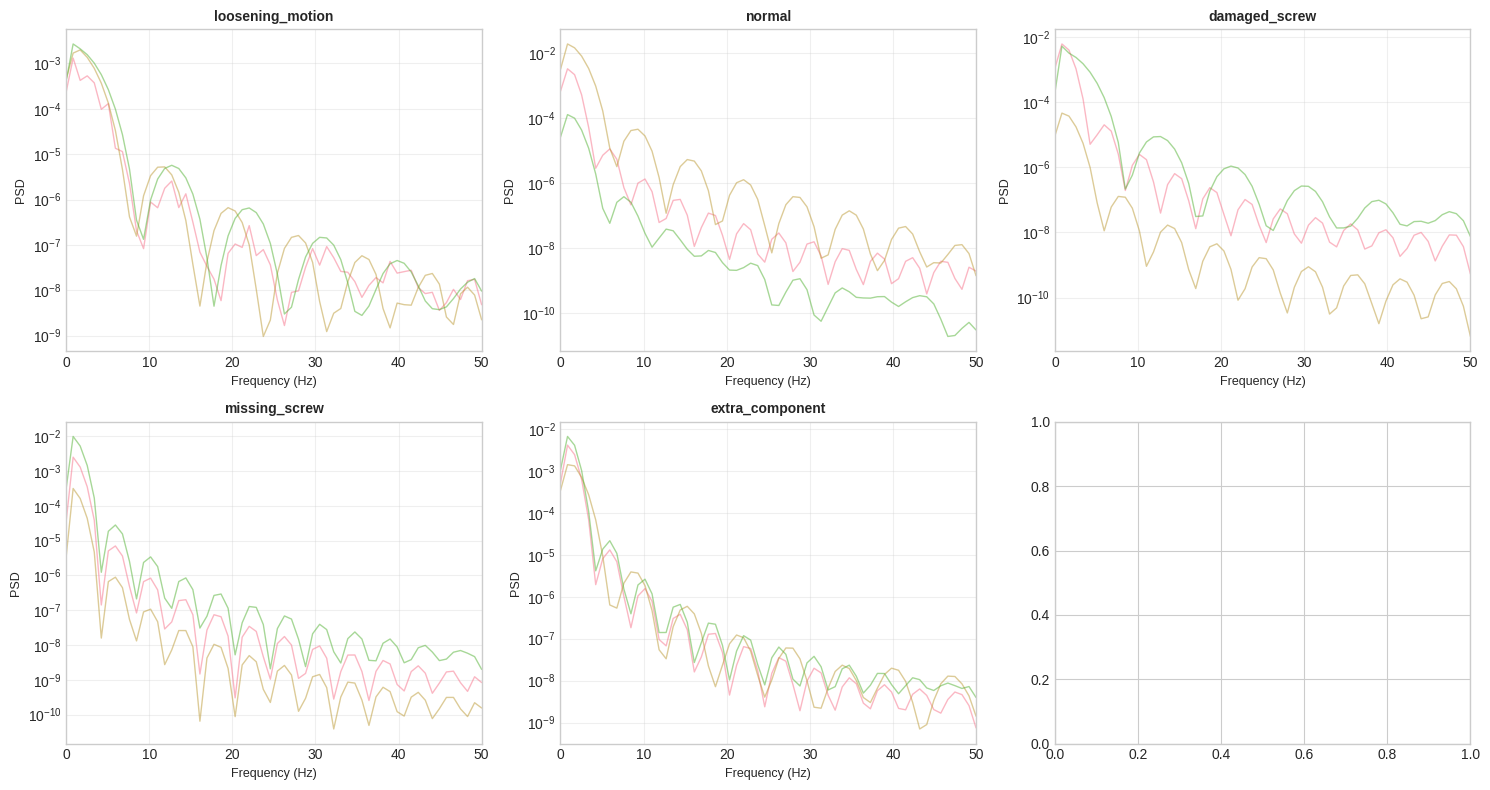

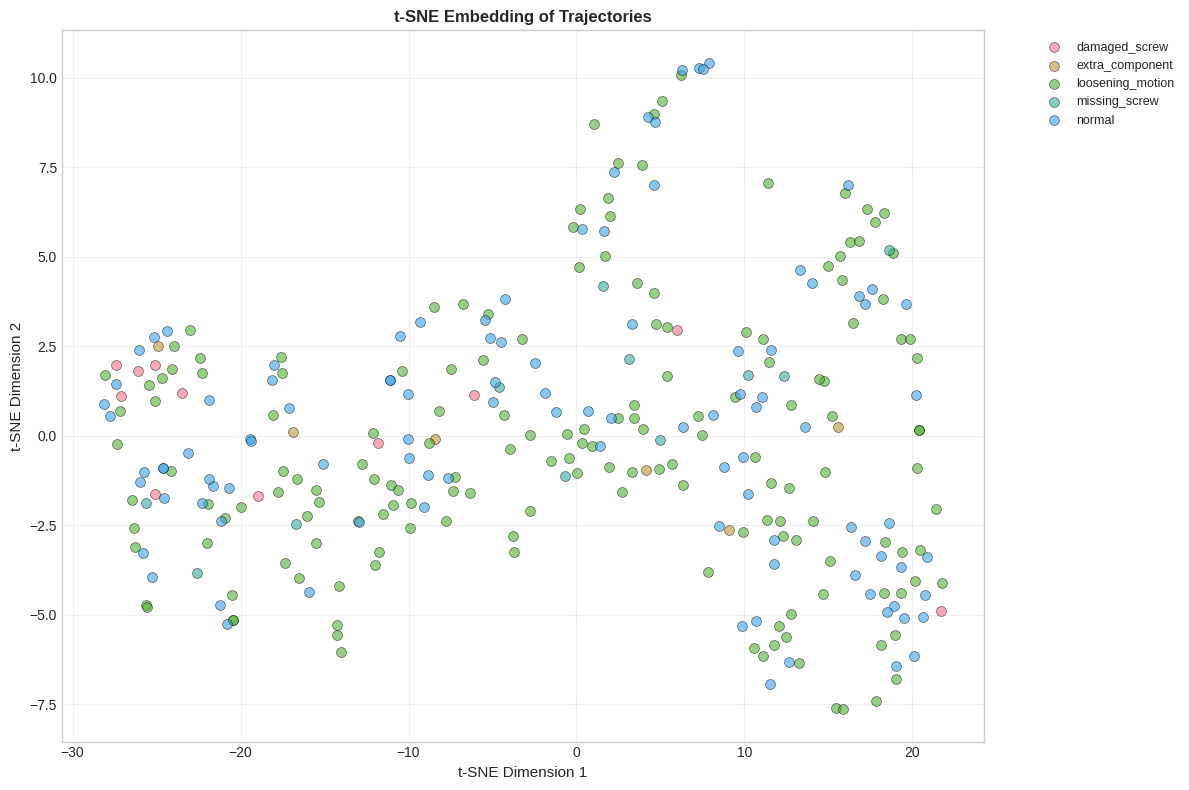

In [14]:
"""
Statistical, temporal, and frequency domain analysis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load data
df = pd.read_pickle('robot_dataset_aursad.pkl')

print(f"\nDataset: {len(df):,} records, {df['sample_id'].nunique():,} trajectories")
print(f"Features: {len([c for c in df.columns if c.startswith(('q', 'qd', 'i'))])}")

labels = df.groupby('sample_id')['label'].first()
class_counts = labels.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution', fontsize=12, fontweight='bold')

# Bar chart
class_counts.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_xlabel('Number of Trajectories')
axes[1].set_title(f'Class Imbalance (Ratio: {imbalance_ratio:.1f}:1)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass Distribution:")
for label, count in class_counts.items():
    print(f"  {label:35s}: {count:4d} ({count/len(labels)*100:5.2f}%)")
print(f"\nImbalance Ratio: {imbalance_ratio:.1f}:1")

# Compute trajectory-level statistics
stats_list = []

for sample_id in df['sample_id'].unique():
    traj = df[df['sample_id'] == sample_id]

    stats_list.append({
        'sample_id': sample_id,
        'label': traj['label'].iloc[0],
        'source': traj['source'].iloc[0],
        'q1_mean': traj['q1'].mean(),
        'q1_std': traj['q1'].std(),
        'qd1_mean': traj['qd1'].mean(),
        'qd1_std': traj['qd1'].std(),
        'qd1_max': traj['qd1'].abs().max(),
        'i1_mean': traj['i1'].mean(),
    })

stats_df = pd.DataFrame(stats_list)

# ANOVA tests

for feature in ['q1_std', 'qd1_std', 'qd1_max', 'i1_mean']:
    groups = [stats_df[stats_df['label'] == label][feature].values for label in class_counts.index]
    f_stat, p_value = stats.f_oneway(*groups)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {feature:15s}: F={f_stat:8.3f}, p={p_value:.4e} {sig}")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

unique_labels = class_counts.index[:9]

for idx, label in enumerate(unique_labels):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]

    sample_ids = labels[labels == label].index[:2]
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        ax.plot(traj['time'], traj['qd1'], alpha=0.7, linewidth=1.5)

    ax.set_xlabel('Time (s)', fontsize=9)
    ax.set_ylabel('Velocity (rad/s)', fontsize=9)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory_samples.png', dpi=150, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, label in enumerate(unique_labels[:6]):
    ax = axes[idx]

    sample_ids = labels[labels == label].index[:3]

    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        signal_data = traj['qd1'].values

        fs = 100.0  # 100 Hz
        freqs, psd = welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)//4))

        ax.semilogy(freqs, psd, alpha=0.5, linewidth=1.0)

    ax.set_xlabel('Frequency (Hz)', fontsize=9)
    ax.set_ylabel('PSD', fontsize=9)
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_xlim([0, 50])
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('frequency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample for t-SNE (computational efficiency)
sample_ids = df['sample_id'].unique()
if len(sample_ids) > 300:
    sample_ids = np.random.choice(sample_ids, 300, replace=False)

tsne_features = []
tsne_labels = []

for sid in sample_ids:
    traj = df[df['sample_id'] == sid]
    tsne_features.append([
        traj['qd1'].mean(),
        traj['qd1'].std(),
        traj['q1'].std(),
        traj['i1'].mean()
    ])
    tsne_labels.append(traj['label'].iloc[0])

X_tsne_input = StandardScaler().fit_transform(tsne_features)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne_input)//4))
X_tsne = tsne.fit_transform(X_tsne_input)

# Plot
plt.figure(figsize=(12, 8))
for label in np.unique(tsne_labels):
    mask = np.array(tsne_labels) == label
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               label=label, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

plt.xlabel('t-SNE Dimension 1', fontsize=11)
plt.ylabel('t-SNE Dimension 2', fontsize=11)
plt.title('t-SNE Embedding of Trajectories', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_embedding.png', dpi=150, bbox_inches='tight')
plt.show()

# Save stats for later use
stats_df.to_pickle('trajectory_statistics.pkl')



## Feature extraction

In [15]:
"""
Extract 287 features from kinematic trajectories
Statistical, Frequency, Wavelet, Temporal, Cross-joint features
"""

import numpy as np
import pandas as pd
from scipy import stats, signal
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import pywt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_pickle('robot_dataset_aursad.pkl')

print(f"\nDataset: {df['sample_id'].nunique()} trajectories")

def extract_statistical_features(signal_data, prefix=''):
    """Statistical features: mean, std, skewness, kurtosis, range, RMS, etc."""
    return {
        f'{prefix}_mean': np.mean(signal_data),
        f'{prefix}_median': np.median(signal_data),
        f'{prefix}_std': np.std(signal_data),
        f'{prefix}_var': np.var(signal_data),
        f'{prefix}_range': np.ptp(signal_data),
        f'{prefix}_iqr': np.percentile(signal_data, 75) - np.percentile(signal_data, 25),
        f'{prefix}_skewness': stats.skew(signal_data),
        f'{prefix}_kurtosis': stats.kurtosis(signal_data),
        f'{prefix}_min': np.min(signal_data),
        f'{prefix}_max': np.max(signal_data),
        f'{prefix}_absmax': np.max(np.abs(signal_data)),
        f'{prefix}_rms': np.sqrt(np.mean(signal_data**2)),
        f'{prefix}_crest_factor': np.max(np.abs(signal_data)) / (np.sqrt(np.mean(signal_data**2)) + 1e-10),
        f'{prefix}_shape_factor': np.sqrt(np.mean(signal_data**2)) / (np.mean(np.abs(signal_data)) + 1e-10)
    }

def extract_frequency_features(signal_data, sampling_rate, prefix=''):
    """Frequency domain features: FFT, PSD, spectral statistics."""
    n = len(signal_data)
    if n < 4:
        return {f'{prefix}_freq_{k}': 0 for k in range(15)}

    # FFT
    fft_vals = np.abs(fft(signal_data))[:n//2]
    freqs = fftfreq(n, 1/sampling_rate)[:n//2]

    # PSD
    if n >= 256:
        freqs_psd, psd = welch(signal_data, fs=sampling_rate, nperseg=min(256, n//4))
    else:
        psd = fft_vals ** 2
        freqs_psd = freqs

    # Dominant frequency
    dominant_idx = np.argmax(fft_vals) if len(fft_vals) > 0 else 0

    # Spectral statistics
    psd_norm = psd / (np.sum(psd) + 1e-10)
    psd_safe = psd_norm[psd_norm > 0]

    # Band powers (0-10, 10-30, 30-50 Hz)
    band_powers = []
    for f_low, f_high in [(0, 10), (10, 30), (30, 50)]:
        mask = (freqs_psd >= f_low) & (freqs_psd < f_high)
        band_powers.append(np.sum(psd[mask]) if np.any(mask) else 0)

    total_power = np.sum(psd)

    return {
        f'{prefix}_dominant_freq': freqs[dominant_idx] if len(freqs) > 0 else 0,
        f'{prefix}_dominant_magnitude': fft_vals[dominant_idx] if len(fft_vals) > 0 else 0,
        f'{prefix}_spectral_centroid': np.sum(freqs_psd * psd_norm),
        f'{prefix}_spectral_spread': np.sqrt(np.sum(((freqs_psd - np.sum(freqs_psd * psd_norm))**2) * psd_norm)),
        f'{prefix}_spectral_entropy': -np.sum(psd_safe * np.log2(psd_safe)) if len(psd_safe) > 0 else 0,
        f'{prefix}_spectral_skewness': stats.skew(psd),
        f'{prefix}_spectral_kurtosis': stats.kurtosis(psd),
        f'{prefix}_power_low': band_powers[0],
        f'{prefix}_power_mid': band_powers[1],
        f'{prefix}_power_high': band_powers[2],
        f'{prefix}_total_power': total_power,
        f'{prefix}_ratio_low': band_powers[0] / (total_power + 1e-10),
        f'{prefix}_ratio_mid': band_powers[1] / (total_power + 1e-10),
        f'{prefix}_ratio_high': band_powers[2] / (total_power + 1e-10),
    }

def extract_wavelet_features(signal_data, prefix='', wavelet='db4', level=4):
    """Wavelet decomposition features."""
    if len(signal_data) < 2**level:
        signal_data = np.pad(signal_data, (0, 2**level - len(signal_data)), mode='edge')

    features = {}
    try:
        coeffs = pywt.wavedec(signal_data, wavelet, level=level)

        for i, coef in enumerate(coeffs):
            level_name = f'a{i}' if i == 0 else f'd{i}'
            features[f'{prefix}_wavelet_{level_name}_energy'] = np.sum(coef**2)
            features[f'{prefix}_wavelet_{level_name}_mean'] = np.mean(coef)
            features[f'{prefix}_wavelet_{level_name}_std'] = np.std(coef)
            features[f'{prefix}_wavelet_{level_name}_max'] = np.max(np.abs(coef))
    except:
        for i in range(level + 1):
            level_name = f'a{i}' if i == 0 else f'd{i}'
            features[f'{prefix}_wavelet_{level_name}_energy'] = 0
            features[f'{prefix}_wavelet_{level_name}_mean'] = 0
            features[f'{prefix}_wavelet_{level_name}_std'] = 0
            features[f'{prefix}_wavelet_{level_name}_max'] = 0

    return features

def extract_temporal_features(signal_data, time_data, prefix=''):
    """Temporal features: autocorrelation, trends, peaks."""
    n = len(signal_data)

    # Autocorrelation
    autocorr = np.correlate(signal_data - np.mean(signal_data),
                           signal_data - np.mean(signal_data), mode='full')
    autocorr = autocorr[len(autocorr)//2:] / (autocorr[len(autocorr)//2] + 1e-10)

    # Trend
    slope = 0
    if len(time_data) > 1:
        slope, _ = np.polyfit(time_data, signal_data, 1)

    # Peaks
    peaks, _ = signal.find_peaks(signal_data)

    features = {}
    for lag in [1, 5, 10, 25]:
        features[f'{prefix}_autocorr_lag{lag}'] = autocorr[lag] if lag < len(autocorr) else 0

    features[f'{prefix}_trend_slope'] = slope
    features[f'{prefix}_zero_crossing_rate'] = np.sum(np.diff(np.sign(signal_data)) != 0) / len(signal_data)
    features[f'{prefix}_peak_count'] = len(peaks)
    features[f'{prefix}_peak_rate'] = len(peaks) / len(signal_data)

    return features

def extract_cross_joint_features(joint_signals):
    """Cross-joint coordination features."""
    features = {}

    # Pairwise correlations
    n_joints = min(3, len(joint_signals))
    for i in range(n_joints):
        for j in range(i+1, n_joints):
            corr = np.corrcoef(joint_signals[i], joint_signals[j])[0, 1]
            features[f'cross_corr_j{i+1}_j{j+1}'] = corr if not np.isnan(corr) else 0

    # Coordination metrics
    joint_means = [np.mean(js) for js in joint_signals]
    joint_stds = [np.std(js) for js in joint_signals]

    features['cross_coordination_mean_std'] = np.std(joint_means)
    features['cross_coordination_std_std'] = np.std(joint_stds)

    return features

def extract_all_features(trajectory_df, sample_id):
    """Extract all 287 features for a single trajectory."""
    features = {
        'sample_id': sample_id,
        'label': trajectory_df['label'].iloc[0],
        'source': trajectory_df['source'].iloc[0],
        'duration': trajectory_df['time'].max() - trajectory_df['time'].min(),
        'n_samples': len(trajectory_df)
    }

    time_data = trajectory_df['time'].values
    sampling_rate = 100.0  # Hz

    # Extract for each joint
    joints = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3']

    for joint in joints:
        if joint not in trajectory_df.columns:
            continue

        signal_data = trajectory_df[joint].values

        # Statistical
        features.update(extract_statistical_features(signal_data, prefix=joint))

        # Frequency
        features.update(extract_frequency_features(signal_data, sampling_rate, prefix=joint))

        # Wavelet (for velocities only)
        if joint.startswith('qd'):
            features.update(extract_wavelet_features(signal_data, prefix=joint))

        # Temporal
        features.update(extract_temporal_features(signal_data, time_data, prefix=joint))

    # Cross-joint
    velocity_signals = [trajectory_df[f'qd{i}'].values for i in range(1, 4)
                       if f'qd{i}' in trajectory_df.columns]
    if len(velocity_signals) >= 2:
        features.update(extract_cross_joint_features(velocity_signals))

    return features

print("\nExtracting features from trajectories...")

feature_list = []
for sample_id in tqdm(df['sample_id'].unique(), desc="Feature Extraction"):
    trajectory = df[df['sample_id'] == sample_id]
    features = extract_all_features(trajectory, sample_id)
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
features_df = features_df.fillna(0)  # Handle any NaN

# Summary
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]

print(f"\nFeature extraction complete!")
print(f"  Trajectories: {len(features_df)}")
print(f"  Features per trajectory: {len(feature_cols)}")

print(f"\nFeature breakdown:")
stat_features = [c for c in feature_cols if any(x in c for x in ['mean', 'std', 'skew', 'kurt', 'rms'])]
freq_features = [c for c in feature_cols if 'freq' in c or 'spectral' in c or 'power' in c]
wavelet_features = [c for c in feature_cols if 'wavelet' in c]
temporal_features = [c for c in feature_cols if 'autocorr' in c or 'trend' in c or 'peak' in c]
cross_features = [c for c in feature_cols if 'cross' in c]

print(f"  Statistical: {len(stat_features)}")
print(f"  Frequency:   {len(freq_features)}")
print(f"  Wavelet:     {len(wavelet_features)}")
print(f"  Temporal:    {len(temporal_features)}")
print(f"  Cross-joint: {len(cross_features)}")

# Save
features_df.to_pickle('robot_features_aursad.pkl')
features_df.head(100).to_csv('robot_features_sample_aursad.csv', index=False)

print(f"Saved: robot_features_aursad.pkl")
print(f"Saved: robot_features_sample_aursad.csv")



Dataset: 4091 trajectories

Extracting features from trajectories...


Feature Extraction:   0%|          | 0/4091 [00:00<?, ?it/s]


Feature extraction complete!
  Trajectories: 4091
  Features per trajectory: 281

Feature breakdown:
  Statistical: 74
  Frequency:   60
  Wavelet:     60
  Temporal:    42
  Cross-joint: 11
Saved: robot_features_aursad.pkl
Saved: robot_features_sample_aursad.csv


## Unsupervised Anomaly Detection


Data split:
  Training (normal): 1420
  Testing (anomaly): 2671

Results:
  F1-Score:  0.6662
  Precision: 1.0000
  Recall:    0.4994

Training LSTM Autoencoder (50 epochs)...
  Epoch 10: Loss = 0.016789
  Epoch 20: Loss = 0.007004
  Epoch 30: Loss = 0.004376
  Epoch 40: Loss = 0.003392
  Epoch 50: Loss = 0.002660

Computing reconstruction errors (batched for memory)...

Results:
  F1-Score:  0.3122
  Precision: 1.0000
  Recall:    0.1849


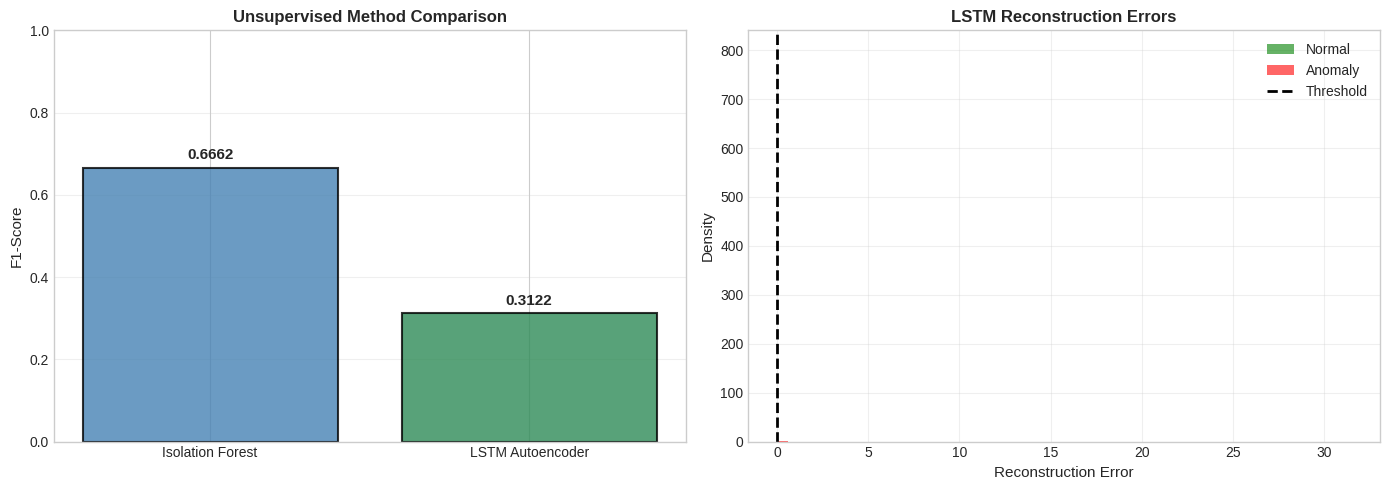


Best Method: Isolation Forest
Best F1: 0.6662


In [16]:
"""
Unsupervised Anomaly Detection
Isolation Forest + LSTM Autoencoder
Train on normal data only, detect anomalies
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load features for Isolation Forest
features_df = pd.read_pickle('robot_features_aursad.pkl')
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples', 'sampling_rate']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]

# Remove constants
feature_cols = [c for c in feature_cols if features_df[c].std() > 0]
features_df[feature_cols] = features_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# Load sequences for LSTM
df = pd.read_pickle('robot_dataset_aursad.pkl')

# Split normal vs anomaly
normal_mask = features_df['label'] == 'normal'

X_train_features = features_df[normal_mask][feature_cols].values
X_test_features = features_df[~normal_mask][feature_cols].values
y_test = (features_df[~normal_mask]['label'] != 'normal').astype(int).values
y_test_labels = features_df[~normal_mask]['label'].values

print(f"\nData split:")
print(f"  Training (normal): {len(X_train_features)}")
print(f"  Testing (anomaly): {len(X_test_features)}")

# Scale features
scaler_if = StandardScaler()
X_train_scaled = scaler_if.fit_transform(X_train_features)
X_test_scaled = scaler_if.transform(X_test_features)

# Train
model_if = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
model_if.fit(X_train_scaled)

# Predict
y_pred_if = model_if.predict(X_test_scaled)
y_pred_binary_if = (y_pred_if == -1).astype(int)
anomaly_scores_if = model_if.decision_function(X_test_scaled)

# Optimize threshold
best_f1_if = 0
for percentile in [10, 20, 30, 40, 50]:
    threshold = np.percentile(anomaly_scores_if, percentile)
    y_pred_thresh = (anomaly_scores_if < threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1_if:
        best_f1_if = f1
        best_pred_if = y_pred_thresh

f1_if = f1_score(y_test, best_pred_if)
precision_if = precision_score(y_test, best_pred_if, zero_division=0)
recall_if = recall_score(y_test, best_pred_if)

print(f"\nResults:")
print(f"  F1-Score:  {f1_if:.4f}")
print(f"  Precision: {precision_if:.4f}")
print(f"  Recall:    {recall_if:.4f}")

# Prepare sequences
def extract_sequences(sample_ids, df):
    sequences = []
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        features = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6']
        seq = traj[features].values

        if len(seq) > 500:
            seq = seq[:500]
        elif len(seq) < 500:
            seq = np.vstack([seq, np.zeros((500 - len(seq), len(features)))])

        sequences.append(seq)
    return np.array(sequences)

normal_ids = features_df[normal_mask]['sample_id'].values
anomaly_ids = features_df[~normal_mask]['sample_id'].values

X_train_seq = extract_sequences(normal_ids, df)
X_test_seq = extract_sequences(anomaly_ids, df)

# Normalize
scaler_lstm = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, X_train_seq.shape[2])
X_train_seq_norm = scaler_lstm.fit_transform(X_train_flat).reshape(X_train_seq.shape)
X_test_flat = X_test_seq.reshape(-1, X_test_seq.shape[2])
X_test_seq_norm = scaler_lstm.transform(X_test_flat).reshape(X_test_seq.shape)

# Model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, 2, batch_first=True, dropout=0.3, bidirectional=True)
        self.decoder = nn.LSTM(hidden_dim*2, hidden_dim, 2, batch_first=True, dropout=0.3)
        self.output = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded, (h, c) = self.encoder(x)
        decoded, _ = self.decoder(encoded)
        return self.output(decoded)

model_lstm = LSTMAutoencoder(input_dim=12, hidden_dim=128).to(device)

# Train
train_loader = DataLoader(torch.FloatTensor(X_train_seq_norm), batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print(f"\nTraining LSTM Autoencoder (50 epochs)...")

for epoch in range(50):
    model_lstm.train()
    epoch_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        reconstructed = model_lstm(batch)
        loss = criterion(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.6f}")

# Evaluate in batches to avoid OOM
model_lstm.eval()

print("\nComputing reconstruction errors (batched for memory)...")

# Train errors (smaller, can do at once)
with torch.no_grad():
    train_recon = model_lstm(torch.FloatTensor(X_train_seq_norm).to(device))
    train_errors = ((torch.FloatTensor(X_train_seq_norm).to(device) - train_recon)**2).mean(dim=(1,2)).cpu().numpy()
    del train_recon
    torch.cuda.empty_cache()

# Test errors (LARGE - process in batches)
test_errors = []
test_batch_size = 32

for i in range(0, len(X_test_seq_norm), test_batch_size):
    batch = X_test_seq_norm[i:i+test_batch_size]
    with torch.no_grad():
        batch_tensor = torch.FloatTensor(batch).to(device)
        batch_recon = model_lstm(batch_tensor)
        batch_errors = ((batch_tensor - batch_recon)**2).mean(dim=(1,2)).cpu().numpy()
        test_errors.extend(batch_errors)

        # Clear GPU memory
        del batch_tensor, batch_recon
        torch.cuda.empty_cache()

test_errors = np.array(test_errors)

threshold_lstm = np.percentile(train_errors, 90)
y_pred_lstm = (test_errors > threshold_lstm).astype(int)

f1_lstm = f1_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, zero_division=0)
recall_lstm = recall_score(y_test, y_pred_lstm)

print(f"\nResults:")
print(f"  F1-Score:  {f1_lstm:.4f}")
print(f"  Precision: {precision_lstm:.4f}")
print(f"  Recall:    {recall_lstm:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Method comparison
methods = ['Isolation Forest', 'LSTM Autoencoder']
f1_scores = [f1_if, f1_lstm]
colors = ['steelblue', 'seagreen']

axes[0].bar(methods, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('F1-Score', fontsize=11)
axes[0].set_title('Unsupervised Method Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for i, (method, score) in enumerate(zip(methods, f1_scores)):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

# Reconstruction error distribution (LSTM)
axes[1].hist(train_errors, bins=50, alpha=0.6, label='Normal', color='green', density=True)
axes[1].hist(test_errors, bins=50, alpha=0.6, label='Anomaly', color='red', density=True)
axes[1].axvline(threshold_lstm, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_xlabel('Reconstruction Error', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('LSTM Reconstruction Errors', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('track1_unsupervised_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_track1 = {
    'isolation_forest': {'f1': f1_if, 'precision': precision_if, 'recall': recall_if},
    'lstm_autoencoder': {'f1': f1_lstm, 'precision': precision_lstm, 'recall': recall_lstm}
}

pd.DataFrame(results_track1).to_csv('track1_results_aursad.csv')

print(f"\nBest Method: {'Isolation Forest' if f1_if > f1_lstm else 'LSTM Autoencoder'}")
print(f"Best F1: {max(f1_if, f1_lstm):.4f}")


## Supervised Classification


 Dataset: 4091 samples, 274 features
  Train: 3272, Test: 819
  After SMOTE: 8195 samples

Accuracy: 0.8327
Balanced Accuracy: 0.6918
Macro F1: 0.6879

Accuracy: 0.8315
Balanced Accuracy: 0.6966
Macro F1: 0.7057


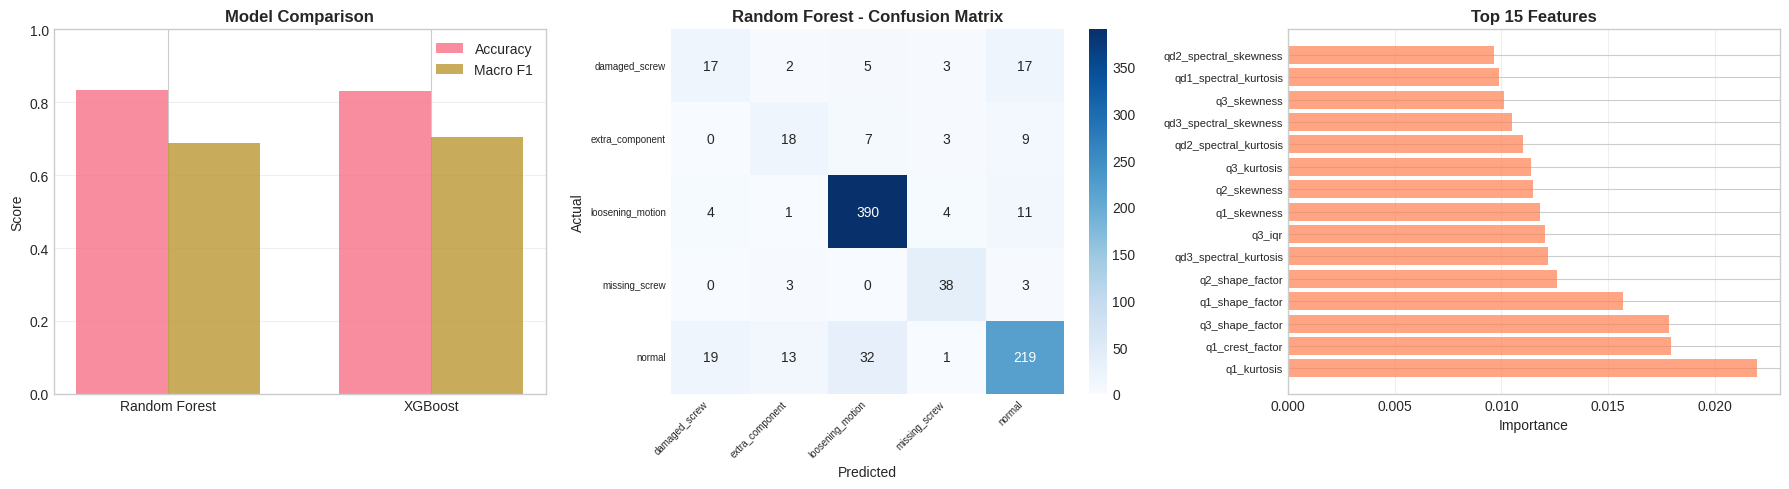


Best Model: Random Forest
Best Accuracy: 0.8327
Best Macro F1: 0.7057


In [17]:
"""
Supervised Classification
Random Forest + XGBoost with SMOTE for class imbalance
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, balanced_accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

features_df = pd.read_pickle('robot_features_aursad.pkl')
metadata_cols = ['sample_id', 'label', 'source', 'duration', 'n_samples', 'sampling_rate']
feature_cols = [c for c in features_df.columns if c not in metadata_cols]
feature_cols = [c for c in feature_cols if features_df[c].std() > 0]

features_df[feature_cols] = features_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n Dataset: {len(features_df)} samples, {len(feature_cols)} features")

# Stratified split
X = features_df[feature_cols].values
y = features_df['label'].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"  Train: {len(X_train)}, Test: {len(X_test)}")

# Apply SMOTE
unique, counts = np.unique(y_train, return_counts=True)
k_neighbors = min(5, min(counts) - 1) if min(counts) > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"  After SMOTE: {len(X_train_balanced)} samples")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced',
                            random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_balanced)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)

print(f"\nAccuracy: {acc_rf:.4f}")
print(f"Balanced Accuracy: {bal_acc_rf:.4f}")
print(f"Macro F1: {report_rf['macro avg']['f1-score']:.4f}")

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_balanced)
y_test_enc = le.transform(y_test)

classes = np.unique(y_train_enc)
weights = compute_class_weight('balanced', classes=classes, y=y_train_enc)
sample_weights = weights[y_train_enc]

xgb = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                   random_state=42, n_jobs=-1, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train_enc, sample_weight=sample_weights)

y_pred_xgb = le.inverse_transform(xgb.predict(X_test_scaled))

acc_xgb = accuracy_score(y_test, y_pred_xgb)
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)

print(f"\nAccuracy: {acc_xgb:.4f}")
print(f"Balanced Accuracy: {bal_acc_xgb:.4f}")
print(f"Macro F1: {report_xgb['macro avg']['f1-score']:.4f}")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model comparison
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [acc_rf, acc_xgb],
    'Macro F1': [report_rf['macro avg']['f1-score'], report_xgb['macro avg']['f1-score']]
})

x_pos = np.arange(len(comparison))
width = 0.35

axes[0].bar(x_pos - width/2, comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison['Macro F1'], width, label='Macro F1', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison['Model'])
axes[0].set_ylabel('Score')
axes[0].set_title('Model Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Confusion matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
unique_labels = np.unique(y_test)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=unique_labels, yticklabels=unique_labels)
axes[1].set_title('Random Forest - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=7)
plt.setp(axes[1].get_yticklabels(), rotation=0, fontsize=7)

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]

axes[2].barh(range(len(indices)), importances[indices], color='coral', alpha=0.7)
axes[2].set_yticks(range(len(indices)))
axes[2].set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Features', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('track2_supervised_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_track2 = {
    'random_forest': {'accuracy': acc_rf, 'macro_f1': report_rf['macro avg']['f1-score']},
    'xgboost': {'accuracy': acc_xgb, 'macro_f1': report_xgb['macro avg']['f1-score']}
}

pd.DataFrame(results_track2).to_csv('track2_results_aursad.csv')

print(f"\nBest Model: {'Random Forest' if acc_rf > acc_xgb else 'XGBoost'}")
print(f"Best Accuracy: {max(acc_rf, acc_xgb):.4f}")
print(f"Best Macro F1: {max(report_rf['macro avg']['f1-score'], report_xgb['macro avg']['f1-score']):.4f}")


## Transfer Learning

In [19]:
"""
Transfer Learning
Pre-train on abundant normal data, fine-tune on limited failures
Knowledge transfer from normal→fault detection
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


df = pd.read_pickle('robot_dataset.pkl')

# Separate normal vs failures
normal_ids = df[df['label'] == 'normal']['sample_id'].unique()
failure_ids = df[df['label'] != 'normal']['sample_id'].unique()

# Split failures: 30% fine-tune, 70% test
np.random.shuffle(failure_ids)
n_finetune = int(len(failure_ids) * 0.3)

finetune_ids = failure_ids[:n_finetune]
test_ids = failure_ids[n_finetune:]

print(f"\nData splits:")
print(f"  Pre-train (normal): {len(normal_ids)}")
print(f"  Fine-tune (failures): {len(finetune_ids)}")
print(f"  Test (held-out): {len(test_ids)}")

# Extract sequences
def extract_sequences(sample_ids):
    sequences, labels = [], []
    for sid in sample_ids:
        traj = df[df['sample_id'] == sid]
        features = ['q1', 'q2', 'q3', 'qd1', 'qd2', 'qd3', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6']
        seq = traj[features].values

        if len(seq) > 500:
            seq = seq[:500]
        elif len(seq) < 500:
            seq = np.vstack([seq, np.zeros((500 - len(seq), len(features)))])

        sequences.append(seq)
        labels.append(traj['label'].iloc[0])

    return np.array(sequences), labels

X_pretrain, _ = extract_sequences(normal_ids)
X_finetune, y_finetune = extract_sequences(finetune_ids)
X_test, y_test = extract_sequences(test_ids)

# Normalize
scaler = StandardScaler()
X_pretrain_norm = scaler.fit_transform(X_pretrain.reshape(-1, 12)).reshape(X_pretrain.shape)
X_finetune_norm = scaler.transform(X_finetune.reshape(-1, 12)).reshape(X_finetune.shape)
X_test_norm = scaler.transform(X_test.reshape(-1, 12)).reshape(X_test.shape)

print(f"Sequences prepared and normalized")

class TransferLSTMClassifier(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=128, num_classes=9):
        super().__init__()

        self.encoder = nn.LSTM(input_dim, hidden_dim, 2, batch_first=True,
                              dropout=0.3, bidirectional=True)
        self.decoder = nn.LSTM(hidden_dim*2, hidden_dim, 2, batch_first=True, dropout=0.3)
        self.reconstruction_head = nn.Linear(hidden_dim, input_dim)

        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_dim*2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.mode = 'pretrain'

    def forward(self, x):
        encoded, _ = self.encoder(x)

        if self.mode == 'pretrain':
            decoded, _ = self.decoder(encoded)
            return self.reconstruction_head(decoded)
        else:
            pooled = encoded.mean(dim=1)
            return self.classifier_head(pooled)


print("PHASE 1: PRE-TRAINING ON NORMAL DATA")

model = TransferLSTMClassifier().to(device)
model.mode = 'pretrain'

train_loader = DataLoader(torch.FloatTensor(X_pretrain_norm), batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nPre-training (50 epochs)...")

for epoch in range(50):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.6f}")

torch.save(model.state_dict(), 'pretrained_model.pth')
print(f"Pre-training complete")

print("PHASE 2: FINE-TUNING ON FAILURE DATA")

model.mode = 'finetune'

# Encode labels
le = LabelEncoder()
y_finetune_enc = le.fit_transform(y_finetune)

# Freeze encoder initially
for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.decoder.parameters():
    param.requires_grad = False

finetune_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_finetune_norm), torch.LongTensor(y_finetune_enc)),
    batch_size=16, shuffle=True
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier_head.parameters(), lr=0.0001)

print(f"\nFine-tuning classifier (30 epochs, encoder frozen)...")

for epoch in range(30):
    model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1} complete")

# Unfreeze and final tune
print(f"\nUnfreezing encoder (10 epochs)...")
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(10):
    model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print(f"Fine-tuning complete")


print("EVALUATION (BATCHED)")

# Force CPU to avoid GPU memory issues
device_eval = torch.device('cpu')
model = model.to(device_eval)

model.eval()

# Batch processing for evaluation
EVAL_BATCH_SIZE = 16
all_predictions = []

print(f"\nEvaluating on {len(X_test_norm)} test samples (batched)...")

for i in tqdm(range(0, len(X_test_norm), EVAL_BATCH_SIZE), desc="Evaluating"):
    batch = X_test_norm[i:i+EVAL_BATCH_SIZE]

    with torch.no_grad():
        batch_tensor = torch.FloatTensor(batch).to(device_eval)
        logits = model(batch_tensor)
        _, predictions = torch.max(logits, 1)
        all_predictions.extend(predictions.cpu().numpy())

        del batch_tensor, logits

    if i % 100 == 0:
        import gc
        gc.collect()

y_pred = le.inverse_transform(all_predictions)

acc_transfer = accuracy_score(y_test, y_pred)
report_transfer = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
macro_f1_transfer = report_transfer['macro avg']['f1-score']

print(f"\nTransfer Learning Results:")
print(f"  Accuracy: {acc_transfer:.4f}")
print(f"  Macro F1: {macro_f1_transfer:.4f}")


print("BASELINE: NO TRANSFER LEARNING")

baseline_model = TransferLSTMClassifier(num_classes=len(le.classes_)).to(device)
baseline_model.mode = 'finetune'

optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print(f"\nTraining from scratch (30 epochs)...")

for epoch in range(30):
    baseline_model.train()
    for batch_x, batch_y in finetune_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = baseline_model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Baseline evaluation (batched)
baseline_model = baseline_model.to(device_eval)
baseline_model.eval()

all_predictions_baseline = []

print(f"\nEvaluating baseline (batched)...")

for i in range(0, len(X_test_norm), EVAL_BATCH_SIZE):
    batch = X_test_norm[i:i+EVAL_BATCH_SIZE]

    with torch.no_grad():
        batch_tensor = torch.FloatTensor(batch).to(device_eval)
        logits = baseline_model(batch_tensor)
        _, predictions = torch.max(logits, 1)
        all_predictions_baseline.extend(predictions.cpu().numpy())

        del batch_tensor, logits
        gc.collect()

y_pred_baseline = le.inverse_transform(all_predictions_baseline)

acc_baseline = accuracy_score(y_test, y_pred_baseline)
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True, zero_division=0)
macro_f1_baseline = report_baseline['macro avg']['f1-score']

print(f"\nBaseline Results:")
print(f"  Accuracy: {acc_baseline:.4f}")
print(f"  Macro F1: {macro_f1_baseline:.4f}")

improvement = ((macro_f1_transfer - macro_f1_baseline) / macro_f1_baseline * 100) if macro_f1_baseline > 0 else 0


# Save
results_track3 = {
    'transfer_learning': {'accuracy': acc_transfer, 'macro_f1': macro_f1_transfer},
    'baseline_no_transfer': {'accuracy': acc_baseline, 'macro_f1': macro_f1_baseline}
}

pd.DataFrame(results_track3).to_csv('track3_results.csv')



Data splits:
  Pre-train (normal): 430
  Fine-tune (failures): 276
  Test (held-out): 644
Sequences prepared and normalized
PHASE 1: PRE-TRAINING ON NORMAL DATA

Pre-training (50 epochs)...
  Epoch 10: Loss = 0.067721
  Epoch 20: Loss = 0.029867
  Epoch 30: Loss = 0.026204
  Epoch 40: Loss = 0.023922
  Epoch 50: Loss = 0.021181
Pre-training complete
PHASE 2: FINE-TUNING ON FAILURE DATA

Fine-tuning classifier (30 epochs, encoder frozen)...
  Epoch 10 complete
  Epoch 20 complete
  Epoch 30 complete

Unfreezing encoder (10 epochs)...
Fine-tuning complete
EVALUATION (BATCHED)

Evaluating on 644 test samples (batched)...


Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]


Transfer Learning Results:
  Accuracy: 0.3168
  Macro F1: 0.1815
BASELINE: NO TRANSFER LEARNING

Training from scratch (30 epochs)...

Evaluating baseline (batched)...

Baseline Results:
  Accuracy: 0.5311
  Macro F1: 0.4306
